# Data Science Assignment: Ship Performance
### Introduction
One of the fundamental problems in maritime transportation is predicting how much fuel will be used on an upcoming voyage. To begin to tackle this problem, we first need a performance model of the ship. Such a model will output a prediction of the rate of fuel usage given a set of features.
The speed of the ship (measured in knots) is the biggest predictor of the rate of main engine fuel usage (measured in metric tonnes per day). In addition, other operating and environmental factors also influence main engine fuel usage: how loaded the ship is (measured via draft [https://en.wikipedia.org/wiki/Draft_(hull)]), wind speed and direction, acceleration/deceleration, rudder angle, time since last maintenance, sea state, current, and others. There are also other highly correlated features to speed which may be useful like engine power, shaft RPM, and GPS distance.
### Data
Included is a zip file of 9422 rows by 20 columns of CSV data from over 1 year on an LPG, VLGC ship (Liquefied Petroleum Gas, Very Large Gas Carrier [https://en.wikipedia.org/wiki/Gas_carrier]). The data contains just a subset of the data we’ve collected on the ship. It includes: fuel rate, fuel type, speed, wind, draft, etc. (More detail in the appendix below.) The original data from the ship was at 1-min samples, and has been downsampled to 1-hour samples in the included CSV. The samples are of both when the ship was at-sea and in-port.
Goal
Using this data, the goal of this assignment is to do the following:
1. Create a machine learning model that outputs a prediction of the rate of main engine fuel usage (mt/day) from a set of feature inputs. (You don’t have to use all the columns of data as features.) 2. Create multiple plots of speed (x-axis) and fuel rate (y-axis) while holding the other
features constant (e.g. draft = 10m, wind = 0 knots). 3. Submit a report detailing the work that was done. 4. Present this report and results during the onsite interview.
Just as important as the model and the graphs is a report documenting the process for how such a model was created. Such a report should be able to answer questions like: what was your process, what else was tried, what failed, how good are the results (describe the error), are the results better under some conditions compared to others, did you throw out some data points, what would you do next if you had more time, any other interesting insights.
Communicating results is as important as getting these results. During the onsite interview, you will be present this report. Feel free to use slides or a “word” document for the report.
You do not need to send any code. We’ve already developed such models at Nautilus Labs, and we don’t want to give any perception that we will steal your work. If your model is good, and described well, we want to hire you.
Please send your report 7 days from receiving this assignment. We will review it, and if it’s good, we’ll schedule an onsite interview for you to present this report.
### Appendix
The columns in the attached CSV are described as follows:
● Main Engine Fuel Consumption (MT/day) - Fuel consumption rate in metric tonnes per day.
● Main Engine Using HFO (bool) - 1.0 if main engine is using Heavy Fuel Oil (a dirty fuel used in open ocean). 0.0 Otherwise. Value could be a fraction if only a portion of the hour is using HFO.
● Main Engine Using MGO (bool) - 1.0 if main engine is using Marine Gas Oil (a clean fuel required near coastal areas and in port). 0.0 Otherwise. Value could be a fraction if only a portion of the hour is using HFO.
● Draft Forward (meters) - Draft sensor in the front of the ship.
● Draft Aft (meters) - Draft sensor in the back of the ship.
● Draft Mid-1 (meters) - Draft sensor in the middle of the ship (unsure if left or right side).
● Draft Mid-2 (meters) - Draft sensor in the middle of the ship (the other side).
● Trim (meters) - (This value is not included as a column as it is trivial to calculate.) Difference between forward and aft draft. Trim has a significant impact on performance.
● Shaft Speed (RPM) - Propeller speed, propeller shaft speed, and main engine speed. There is no gear box. The engine turns at ~90 RPM max.
● Shaft Torque (kNm) - Torque on the above shaft.
● Shaft Power (kW) - Main engine output as measured in power.
● Speed Over Ground (knots) - Speed as measured from the frame of reference of GPS or an on-ground observer. A “stopped” ship could still have speed over ground as it is flowing with the current.
● Speed Through Water (knots) - Speed as measured from the frame of reference of a log floating in the water. Also called “log speed” for that exact reason. A “stopped” ship should have 0 speed through water. However, a moored ship may have speed through water as the water moves past the ship.
● Heading (degrees) - Ship heading.
● Rudder Angle (degrees) - Angle of the rudder.
● Weather Service True Wind Speed (knots) - Wind speed as measured and recorded by NOAA relative to a stationary object.
● Weather Service True Wind Direction (degrees from north) - Wind direction as measured and recorded by NOAA relative to a stationary object.
● Weather Service Apparent Wind Speed (knots) - Wind speed as measured and recorded by NOAA relative to the ship’s vector.
● Weather Service Apparent Wind Direction (degrees from bow) - Wind direction as measured and recorded by NOAA relative to the ship’s vector.
● Weather Service Temperature (celsius) - Water surface temperature.
● Water Depth (meters) - Depth below the keel. Unfortunately, value is zero in deep water.


In [1]:
!pwd

/Users/etheredgej/GitHub/Project_Euler_Solutions


In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import pandas_profiling as pp

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

import numpy as np
from math import sqrt

/Users/etheredgej/anaconda/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/etheredgej/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/etheredgej/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/etheredgej/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/etheredgej/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/etheredgej/anaconda/lib/python3.6/site-packages/ipykernel/kernela

In [3]:
df = pd.read_csv("/Users/etheredgej/Desktop/cheyenne-Aug-6.csv")

In [4]:
df.head()

Time  Main Engine Fuel Consumption (MT/day)  \
0  1499346900                              39.459546   
1  1499349600                              39.068840   
2  1499353200                              39.033464   
3  1499356800                              39.319707   
4  1499360400                              39.409119   

   Main Engine Using HFO (bool)  Main Engine Using MGO (bool)  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   Draft Forward (meters)  Draft Aft (meters)  Draft Mid-1 (meters)  \
0                     0.0                 0.0                   0.0   
1                     0.0                 0.0                   0.0   
2                     0.0                 0.0                   0.0   
3                     0.0                 0.0                   0.0   
4                     0.0                 0.0                   0.0   

   Draft Mid-2 (meters)  Shaft Speed (RPM)  Shaft Torque (kNm)  \
0             11.497695          84.878837         1013.631639   
1             11.509352          84.868300         1004.244559   
2             11.531678          84.874972         1003.751648   
3             11.545624          84.867446         1010.716545   
4             11.549795          84.864535         1013.179696   

           ...           Speed Over Ground (knots)  \
0          ...                           15.463448   
1          ...                           15.744354   
2          ...                           15.939796   
3          ...                           16.135230   
4          ...                           16.176168   

   Speed Through Water (knots)  Heading (degrees)  Rudder Angle (degrees)  \
0                    15.607449         167.741687              358.025169   
1                    15.776289         168.034239              357.967447   
2                    15.707046         152.496507              358.605730   
3                    15.723442         128.601049              358.864694   
4                    15.692471         107.945165              358.951153   

   Weather Service Apparent Wind Speed (knots)  \
0                                    10.562147   
1                                    11.235847   
2                                     9.877020   
3                                     7.794503   
4                                     8.224946   

   Weather Service Apparent Wind Direction (degrees from bow)  \
0                                         -20.425280            
1                                         -23.426525            
2                                         -22.396395            
3                                          -8.588757            
4                                          15.548503            

   Weather Service True Wind Speed (knots)  \
0                                 6.675338   
1                                 7.034936   
2                                 7.778708   
3                                 8.508143   
4                                 8.541663   

   Weather Service True Wind Direction (degrees from north)  \
0                                         314.224484          
1                                         308.615498          
2                                         303.563245          
3                                         300.737464          
4                                         302.903396          

   Weather Service Temperature (celsius)  Water Depth (meters)  
0                              20.283070                   0.0  
1                              20.360866                   0.0  
2                              20.534435                   0.0  
3                              20.641539                   0.

In [5]:
pp.ProfileReport(df)

## X and y creation

In [6]:
y = df['Main Engine Fuel Consumption (MT/day)']
X = df.drop(['Main Engine Fuel Consumption (MT/day)'], axis=1)

## LassoCV no holdout

In [7]:
reg = LassoCV(cv=10, random_state=42).fit(X, y)
y_pred = reg.predict(X)
print("mean squared error:", mean_squared_error(y, y_pred))
print("root mean squared error:", sqrt(mean_squared_error(y, y_pred)))
print("mean absolute error:", mean_absolute_error(y, y_pred))
print("median absolute error:", median_absolute_error(y, y_pred))

mean squared error: 29.092935788722944
root mean squared error: 5.393786776349519
mean absolute error: 3.8914365227104937
median absolute error: 4.228377343321036


## 30% holdout creation

In [8]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.30, random_state=42)

## LassoCV 30% holdout

In [9]:
reg = LassoCV(cv=10, random_state=42).fit(X_train, y_train)
y_pred = reg.predict(X_holdout)
print("mean squared error:", mean_squared_error(y_holdout, y_pred))
print("root mean squared error:", sqrt(mean_squared_error(y_holdout, y_pred)))
print("mean absolute error:", mean_absolute_error(y_holdout, y_pred))
print("median absolute error:", median_absolute_error(y_holdout, y_pred))

mean squared error: 34.792382923261
root mean squared error: 5.89850683845166
mean absolute error: 4.070074239237602
median absolute error: 4.33096293426523


In [10]:
alphas = np.logspace(-10, 1, 400)
reg = LassoCV(cv=10, alphas=alphas, random_state=42).fit(X_train, y_train)
y_pred = reg.predict(X_holdout)
print("mean squared error:", mean_squared_error(y_holdout, y_pred))
print("root mean squared error:", sqrt(mean_squared_error(y_holdout, y_pred)))
print("mean absolute error:", mean_absolute_error(y_holdout, y_pred))
print("median absolute error:", median_absolute_error(y_holdout, y_pred))

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


mean squared error: 2.7201305112693244
root mean squared error: 1.6492818168127983
mean absolute error: 0.7819861270940971
median absolute error: 0.5163968815493405


/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso

for Model in [Ridge, Lasso]:
    model = Model()
    print('%s: %s' % (Model.__name__,
                      cross_val_score(model, X, y, scoring='mean_squared_error').mean()))

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.863168e-18
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.554883e-18
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

Ridge: -17.66648653060948
Lasso: -16.034807244590045


/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


## We compute the cross-validation score as a function of alpha, the strength of the regularization for Lasso and Ridge

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.292173e-19
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.296740e-19
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.069769e-19
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.113835e-18
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.328070e-19
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.292174e-19
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.113837e-18
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.32809

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.328345e-19
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.292324e-19
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.298068e-19
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.071278e-19
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.084858e-19
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.116408e-18
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.220664e-19
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.139566e-18
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.578726e-19
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.371142e-18
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.315979e-18
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.687031e-18
  overwrite_a=True).T
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

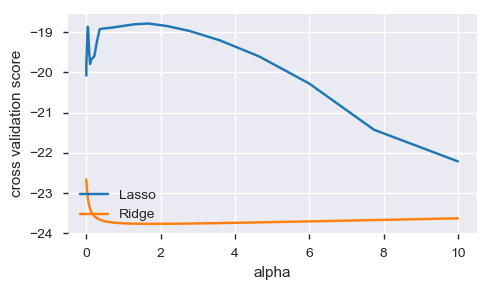

In [12]:
import numpy as np
from matplotlib import pyplot as plt

alphas = np.logspace(-10, 1, 100)

plt.figure(figsize=(5, 3))

for Model in [Lasso, Ridge]:
    scores = [cross_val_score(Model(alpha), X, y, cv=5, scoring='mean_squared_error').mean()
            for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

In [13]:
np.min(scores)

-23.760652445069123

In [14]:
X

Time  Main Engine Using HFO (bool)  Main Engine Using MGO (bool)  \
0     1499346900                           0.0                           0.0   
1     1499349600                           0.0                           0.0   
2     1499353200                           0.0                           0.0   
3     1499356800                           0.0                           0.0   
4     1499360400                           0.0                           0.0   
5     1499364000                           0.0                           0.0   
6     1499367600                           0.0                           0.0   
7     1499371200                           0.0                           0.0   
8     1499374800                           0.0                           0.0   
9     1499378400                           0.0                           0.0   
10    1499382000                           0.0                           0.0   
11    1499385600                           0.0                           0.0   
12    1499389200                           0.0                           0.0   
13    1499392800                           0.0                           0.0   
14    1499396400                           0.0                           0.0   
15    1499400000                           0.0                           0.0   
16    1499403600                           0.0                           0.0   
17    1499407200                           0.0                           0.0   
18    1499410800                           0.0                           0.0   
19    1499414400                           0.0                           0.0   
20    1499418000                           0.0                           0.0   
21    1499421600                           0.0                           0.0   
22    1499425200                           0.0                           0.0   
23    1499428800                           0.0                           0.0   
24    1499432400                           0.0                           0.0   
25    1499436000                           0.0                           0.0   
26    1499439600                           0.0                           0.0   
27    1499443200                           0.0                           0.0   
28    1499446800                           0.0                           0.0   
29    1499450400                           0.0                           0.0   
...          ...                           ...                           ...   
9392  1533488400                           0.0                           1.0   
9393  1533492000                           0.0                           1.0   
9394  1533495600                           0.0                           1.0   
9395  1533499200                           0.0                           1.0   
9396  1533502800                           0.0                           1.0   
9397  1533506400                           0.0                           1.0   
9398  1533510000                           0.0                           1.0   
9399  1533513600                           0.0                           1.0   
9400  1533517200                           0.0                           1.0   
9401  1533520800                           0.0                           1.0   
9402  1533524400                           0.0                           1.0   
9403  1533528000                           0.0                           1.0   
9404  1533531600                           0.0                           1.0   
9405  1533535200                           0.0                           1.0   
9406  1533538800                           0.0                           1.0   
9407  1533542400                           0.0                           1.0   
9408  1533546000                           0.0                           1.0   
9409  1533549600                           0.0                           1.0   
9410  153355

## Plot original data

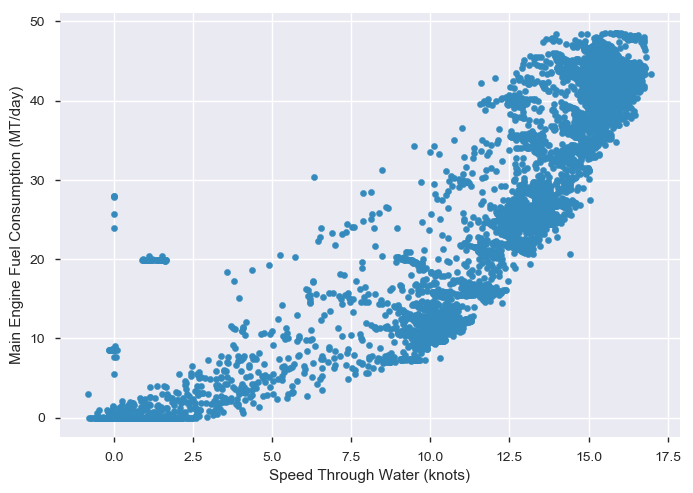

In [15]:
df.plot(x='Speed Through Water (knots)',y='Main Engine Fuel Consumption (MT/day)', kind='scatter')

## Plot predicted data with modified variables

In [16]:
X_train.columns

Index(['Time', 'Main Engine Using HFO (bool)', 'Main Engine Using MGO (bool)',
       'Draft Forward (meters)', 'Draft Aft (meters)', 'Draft Mid-1 (meters)',
       'Draft Mid-2 (meters)', 'Shaft Speed (RPM)', 'Shaft Torque (kNm)',
       'Shaft Power (kW)', 'Speed Over Ground (knots)',
       'Speed Through Water (knots)', 'Heading (degrees)',
       'Rudder Angle (degrees)', 'Weather Service Apparent Wind Speed (knots)',
       'Weather Service Apparent Wind Direction (degrees from bow)',
       'Weather Service True Wind Speed (knots)',
       'Weather Service True Wind Direction (degrees from north)',
       'Weather Service Temperature (celsius)', 'Water Depth (meters)'],
      dtype='object')

## Get best hyperparameterized lasso model

In [ ]:
alphas = np.logspace(-10, 1, 400)
reg = LassoCV(cv=10, alphas=alphas, random_state=42).fit(X_train, y_train)
y_pred = reg.predict(X_holdout)
print("mean squared error:", mean_squared_error(y_holdout, y_pred))
print("root mean squared error:", sqrt(mean_squared_error(y_holdout, y_pred)))
print("mean absolute error:", mean_absolute_error(y_holdout, y_pred))
print("median absolute error:", median_absolute_error(y_holdout, y_pred))

In [ ]:
colset = set(X.columns)
colset.remove('Speed Through Water (knots)')
boolcols = {'Main Engine Using HFO (bool)', 'Main Engine Using MGO (bool)'}

In [56]:
print(colset, boolcols)

{'Main Engine Using HFO (bool)', 'Draft Mid-1 (meters)', 'Shaft Torque (kNm)', 'Rudder Angle (degrees)', 'Weather Service Apparent Wind Speed (knots)', 'Main Engine Using MGO (bool)', 'Water Depth (meters)', 'Shaft Speed (RPM)', 'Weather Service True Wind Direction (degrees from north)', 'Shaft Power (kW)', 'Draft Forward (meters)', 'Draft Mid-2 (meters)', 'Weather Service Apparent Wind Direction (degrees from bow)', 'Weather Service Temperature (celsius)', 'Weather Service True Wind Speed (knots)', 'Speed Over Ground (knots)', 'Heading (degrees)', 'Draft Aft (meters)', 'Time'} {'Main Engine Using HFO (bool)', 'Main Engine Using MGO (bool)'}


In [58]:
for col in colset:
    print(col)
    subcolset = colset.copy()
    subcolset.remove(col)
    print(len(colset))
    print(len(subcolset))
    X_modded = X.copy()
    X_modded[subcol].median()
    for subcol in subcolset:
        print(subcol)
        X_modded[subcol] = X_modded[subcol].median()
    print(col)
    X_modded[col] = X_modded[col].max()
X_modded.head()

Main Engine Using HFO (bool)
19
18
Draft Mid-1 (meters)
Shaft Torque (kNm)
Main Engine Using MGO (bool)
Shaft Power (kW)
Weather Service Apparent Wind Direction (degrees from bow)
Draft Mid-2 (meters)
Weather Service Temperature (celsius)
Speed Over Ground (knots)
Weather Service True Wind Speed (knots)
Heading (degrees)
Draft Aft (meters)
Time
Rudder Angle (degrees)
Weather Service Apparent Wind Speed (knots)
Water Depth (meters)
Shaft Speed (RPM)
Draft Forward (meters)
Weather Service True Wind Direction (degrees from north)
Main Engine Using HFO (bool)
Draft Mid-1 (meters)
19
18
Shaft Torque (kNm)
Main Engine Using MGO (bool)
Shaft Power (kW)
Weather Service Apparent Wind Direction (degrees from bow)
Draft Mid-2 (meters)
Weather Service Temperature (celsius)
Speed Over Ground (knots)
Weather Service True Wind Speed (knots)
Heading (degrees)
Draft Aft (meters)
Time
Main Engine Using HFO (bool)
Rudder Angle (degrees)
Weather Service Apparent Wind Speed (knots)
Water Depth (meters)
Sha

Time  Main Engine Using HFO (bool)  Main Engine Using MGO (bool)  \
0  1533591900                           1.0                           0.0   
1  1533591900                           1.0                           0.0   
2  1533591900                           1.0                           0.0   
3  1533591900                           1.0                           0.0   
4  1533591900                           1.0                           0.0   

   Draft Forward (meters)  Draft Aft (meters)  Draft Mid-1 (meters)  \
0                6.116378            8.476348              7.086885   
1                6.116378            8.476348              7.086885   
2                6.116378            8.476348              7.086885   
3                6.116378            8.476348              7.086885   
4                6.116378            8.476348              7.086885   

   Draft Mid-2 (meters)  Shaft Speed (RPM)  Shaft Torque (kNm)  \
0              7.127917          61.065734          546.216522   
1              7.127917          61.065734          546.216522   
2              7.127917          61.065734          546.216522   
3              7.127917          61.065734          546.216522   
4              7.127917          61.065734          546.216522   

   Shaft Power (kW)  Speed Over Ground (knots)  Speed Through Water (knots)  \
0       3415.093424                  11.164813                    15.607449   
1       3415.093424                  11.164813                    15.776289   
2       3415.093424                  11.164813                    15.707046   
3       3415.093424                  11.164813                    15.723442   
4       3415.093424                  11.164813                    15.692471   

   Heading (degrees)  Rudder Angle (degrees)  \
0         230.493197              358.705003   
1         230.493197              358.705003   
2         230.493197              358.705003   
3         230.493197              358.705003   
4         230.493197              358.705003   

   Weather Service Apparent Wind Speed (knots)  \
0                                    13.509745   
1                                    13.509745   
2                                    13.509745   
3                                    13.509745   
4                                    13.509745   

   Weather Service Apparent Wind Direction (degrees from bow)  \
0                                          12.149247            
1                                          12.149247            
2                                          12.149247            
3                                          12.149247            
4                                          12.149247            

   Weather Service True Wind Speed (knots)  \
0                                10.916345   
1                                10.916345   
2                                10.916345   
3                                10.916345   
4                                10.916345   

   Weather Service True Wind Direction (degrees from north)  \
0                                              180.0          
1                                              180.0          
2                                              180.0          
3                                              180.0          
4                                              180.0          

   Weather Service Temperature (celsius)  Water Depth (meters)  
0                              23.837212                   0.0  
1                              23.837212                   0.0  
2                              23.837212                   0.0  
3                              23.837212                   0.0  
4                              23.837212                   0.0

In [59]:
for col in colset:
    print(col)
    subcolset = colset.copy()
    subcolset.remove(col)
    print(len(colset))
    print(len(subcolset))
    X_modded = X.copy()
    X_modded[subcol].median()
    for subcol in subcolset:
        print(subcol)
        X_modded[subcol] = X_modded[subcol].median()
    print(col)
    X_modded[col] = X_modded[col].mean()
X_modded.head()

Main Engine Using HFO (bool)
19
18
Draft Mid-1 (meters)
Shaft Torque (kNm)
Main Engine Using MGO (bool)
Shaft Power (kW)
Weather Service Apparent Wind Direction (degrees from bow)
Draft Mid-2 (meters)
Weather Service Temperature (celsius)
Speed Over Ground (knots)
Weather Service True Wind Speed (knots)
Heading (degrees)
Draft Aft (meters)
Time
Rudder Angle (degrees)
Weather Service Apparent Wind Speed (knots)
Water Depth (meters)
Shaft Speed (RPM)
Draft Forward (meters)
Weather Service True Wind Direction (degrees from north)
Main Engine Using HFO (bool)
Draft Mid-1 (meters)
19
18
Shaft Torque (kNm)
Main Engine Using MGO (bool)
Shaft Power (kW)
Weather Service Apparent Wind Direction (degrees from bow)
Draft Mid-2 (meters)
Weather Service Temperature (celsius)
Speed Over Ground (knots)
Weather Service True Wind Speed (knots)
Heading (degrees)
Draft Aft (meters)
Time
Main Engine Using HFO (bool)
Rudder Angle (degrees)
Weather Service Apparent Wind Speed (knots)
Water Depth (meters)
Sha

Time  Main Engine Using HFO (bool)  Main Engine Using MGO (bool)  \
0  1.516314e+09                           1.0                           0.0   
1  1.516314e+09                           1.0                           0.0   
2  1.516314e+09                           1.0                           0.0   
3  1.516314e+09                           1.0                           0.0   
4  1.516314e+09                           1.0                           0.0   

   Draft Forward (meters)  Draft Aft (meters)  Draft Mid-1 (meters)  \
0                6.116378            8.476348              7.086885   
1                6.116378            8.476348              7.086885   
2                6.116378            8.476348              7.086885   
3                6.116378            8.476348              7.086885   
4                6.116378            8.476348              7.086885   

   Draft Mid-2 (meters)  Shaft Speed (RPM)  Shaft Torque (kNm)  \
0              7.127917          61.065734          546.216522   
1              7.127917          61.065734          546.216522   
2              7.127917          61.065734          546.216522   
3              7.127917          61.065734          546.216522   
4              7.127917          61.065734          546.216522   

   Shaft Power (kW)  Speed Over Ground (knots)  Speed Through Water (knots)  \
0       3415.093424                  11.164813                    15.607449   
1       3415.093424                  11.164813                    15.776289   
2       3415.093424                  11.164813                    15.707046   
3       3415.093424                  11.164813                    15.723442   
4       3415.093424                  11.164813                    15.692471   

   Heading (degrees)  Rudder Angle (degrees)  \
0         230.493197              358.705003   
1         230.493197              358.705003   
2         230.493197              358.705003   
3         230.493197              358.705003   
4         230.493197              358.705003   

   Weather Service Apparent Wind Speed (knots)  \
0                                    13.509745   
1                                    13.509745   
2                                    13.509745   
3                                    13.509745   
4                                    13.509745   

   Weather Service Apparent Wind Direction (degrees from bow)  \
0                                          12.149247            
1                                          12.149247            
2                                          12.149247            
3                                          12.149247            
4                                          12.149247            

   Weather Service True Wind Speed (knots)  \
0                                10.916345   
1                                10.916345   
2                                10.916345   
3                                10.916345   
4                                10.916345   

   Weather Service True Wind Direction (degrees from north)  \
0                                              180.0          
1                                              180.0          
2                                              180.0          
3                                              180.0          
4                                              180.0          

   Weather Service Temperature (celsius)  Water Depth (meters)  
0                              23.837212                   0.0  
1                              23.837212                   0.0  
2                              23.837212                   0.0  
3                              23.837212                   0.0  
4                              23.837212                   0.0

Draft Mid-1 (meters) 0.05 quantile = 6.469248375602788
Draft Mid-1 (meters) 0.25 quantile = 6.7991206482681195
Draft Mid-1 (meters) 0.5 quantile = 7.086884864723718
Draft Mid-1 (meters) 0.75 quantile = 10.42301126983949
Draft Mid-1 (meters) 0.95 quantile = 11.646670280125052
Shaft Torque (kNm) 0.05 quantile = 1.1706284661969621
Shaft Torque (kNm) 0.25 quantile = 6.952336694234671
Shaft Torque (kNm) 0.5 quantile = 546.2165220731185
Shaft Torque (kNm) 0.75 quantile = 1009.9955511061489
Shaft Torque (kNm) 0.95 quantile = 1122.5206256402475
Rudder Angle (degrees) 0.05 quantile = 1.3772598712608033
Rudder Angle (degrees) 0.25 quantile = 357.51659329569185
Rudder Angle (degrees) 0.5 quantile = 358.7050028927408
Rudder Angle (degrees) 0.75 quantile = 359.204275790893
Rudder Angle (degrees) 0.95 quantile = 359.6276391539832
Weather Service Apparent Wind Speed (knots) 0.05 quantile = 2.7700525441256056
Weather Service Apparent Wind Speed (knots) 0.25 quantile = 7.746740387201536
Weather Service

/Users/etheredgej/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Water Depth (meters) 0.05 quantile = 0.0
Water Depth (meters) 0.25 quantile = 0.0
Water Depth (meters) 0.5 quantile = 0.0
Water Depth (meters) 0.75 quantile = 12.0
Water Depth (meters) 0.95 quantile = 147.0
Shaft Speed (RPM) 0.05 quantile = 0.0
Shaft Speed (RPM) 0.25 quantile = 0.0
Shaft Speed (RPM) 0.5 quantile = 61.06573389882399
Shaft Speed (RPM) 0.75 quantile = 83.74169966514555
Shaft Speed (RPM) 0.95 quantile = 87.67049347587634
Weather Service True Wind Direction (degrees from north) 0.05 quantile = 16.928126247983425
Weather Service True Wind Direction (degrees from north) 0.25 quantile = 71.08444997959288
Weather Service True Wind Direction (degrees from north) 0.5 quantile = 180.0
Weather Service True Wind Direction (degrees from north) 0.75 quantile = 280.41892646053805
Weather Service True Wind Direction (degrees from north) 0.95 quantile = 344.7394151119161
Shaft Power (kW) 0.05 quantile = 5.966663052837275
Shaft Power (kW) 0.25 quantile = 6.651526412377562
Shaft Power (kW)

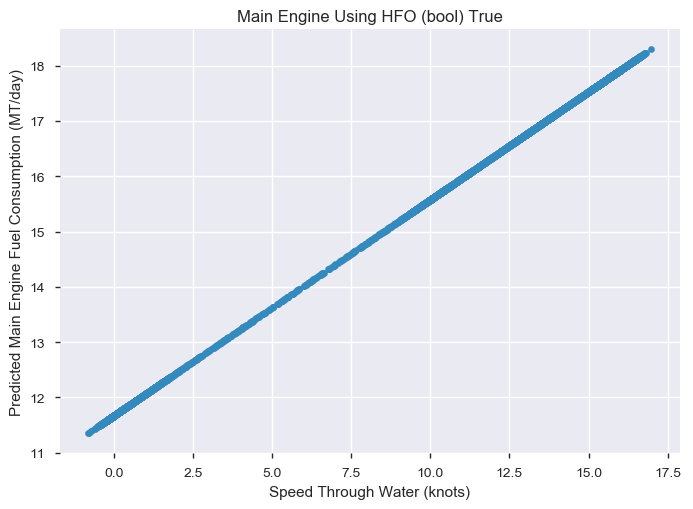

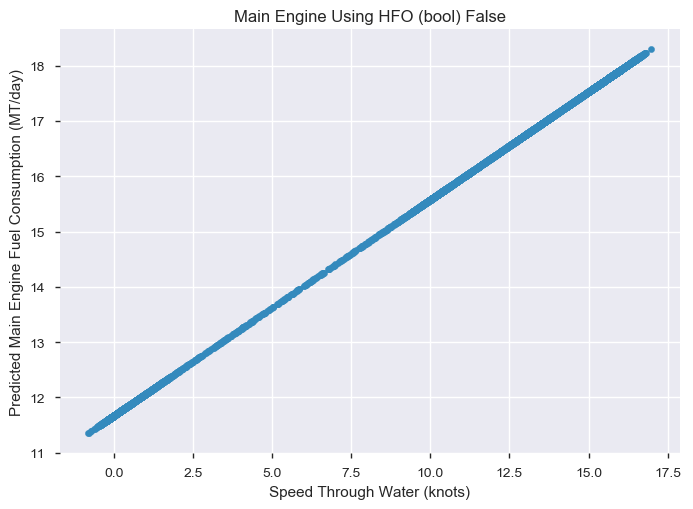

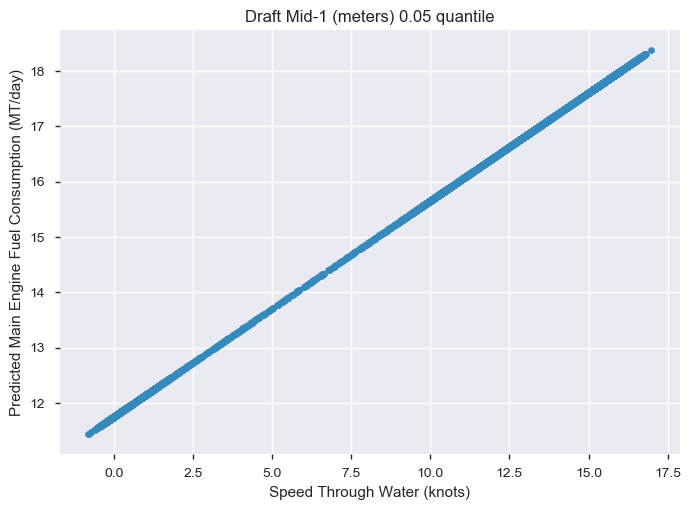

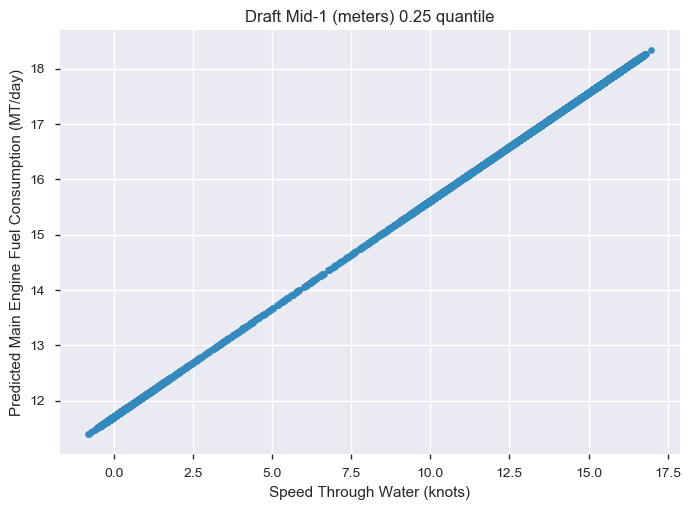

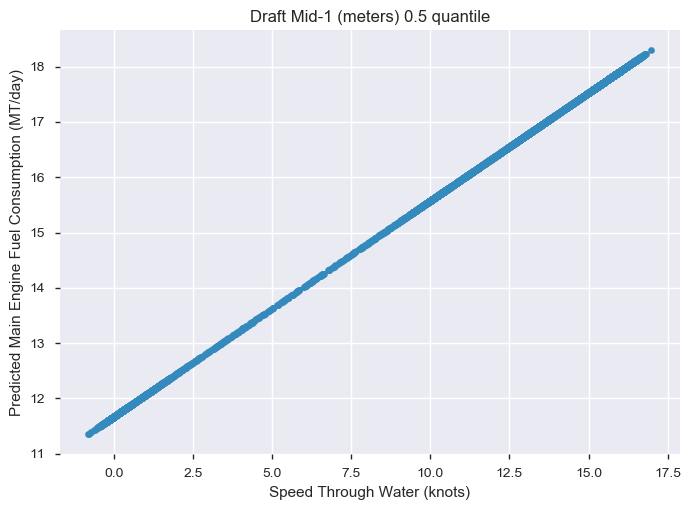

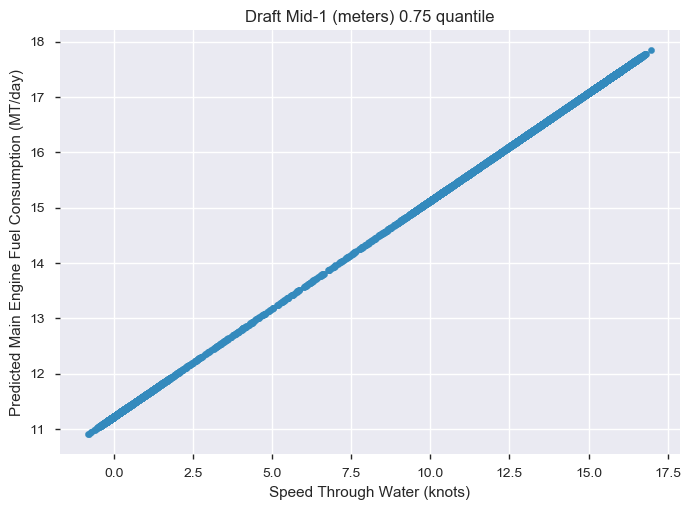

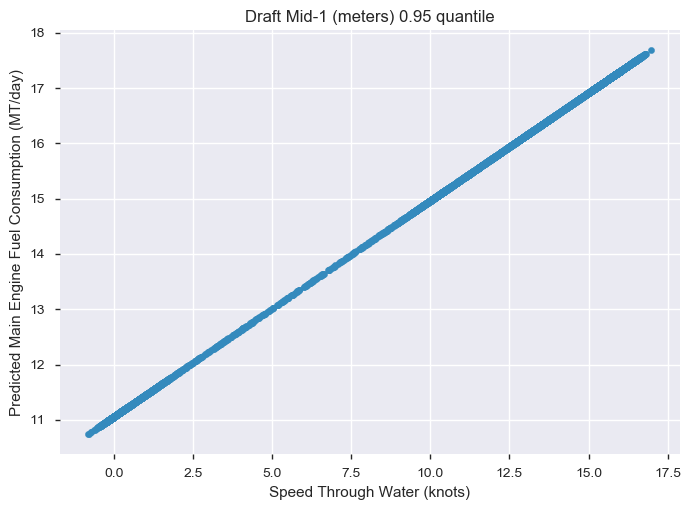

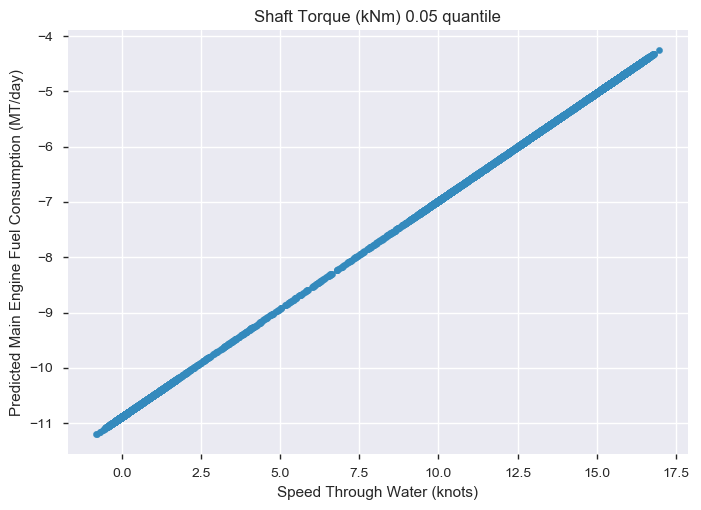

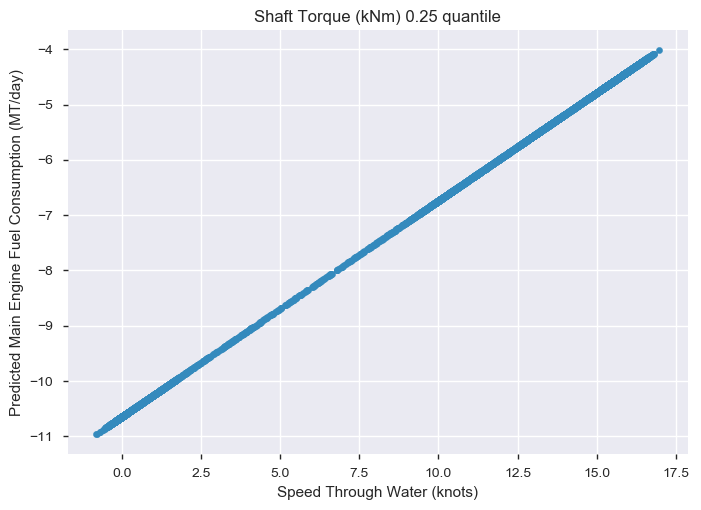

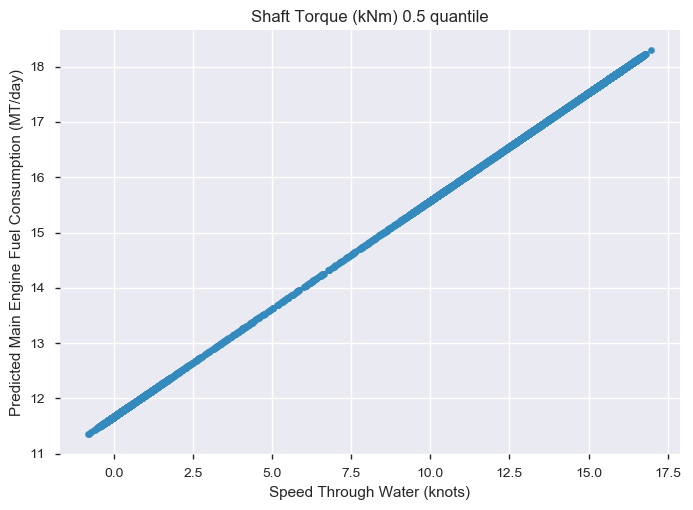

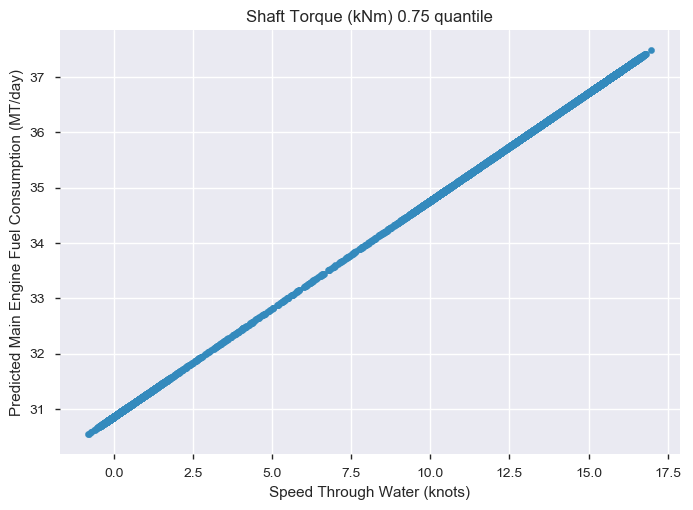

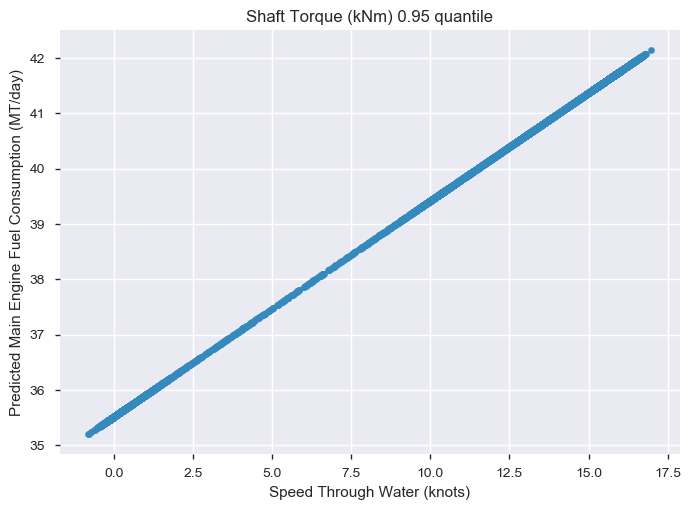

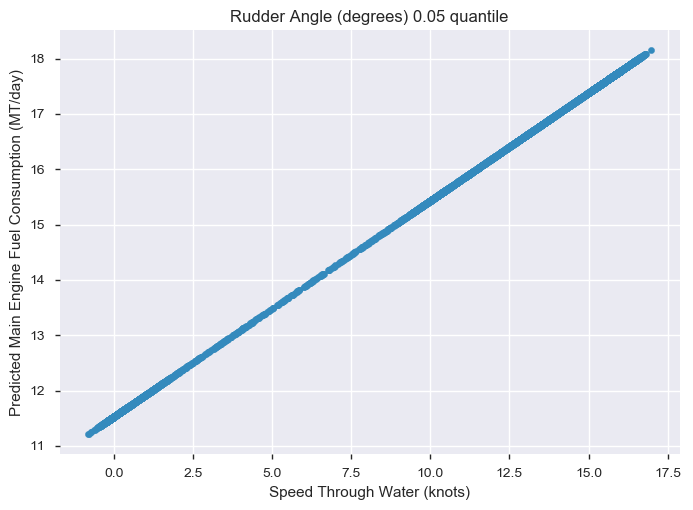

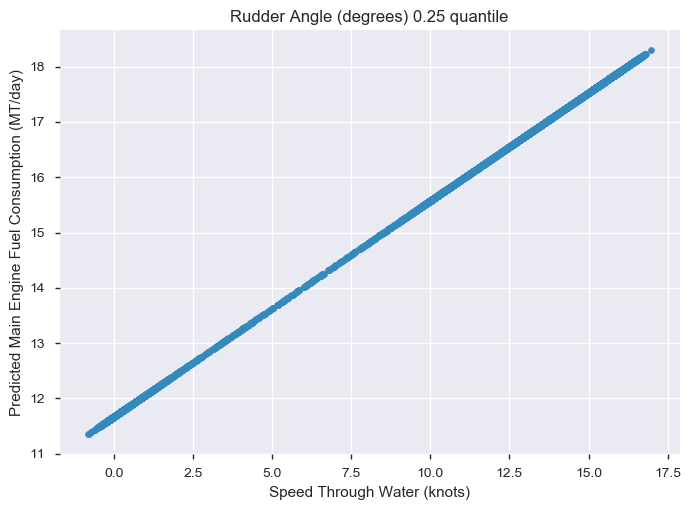

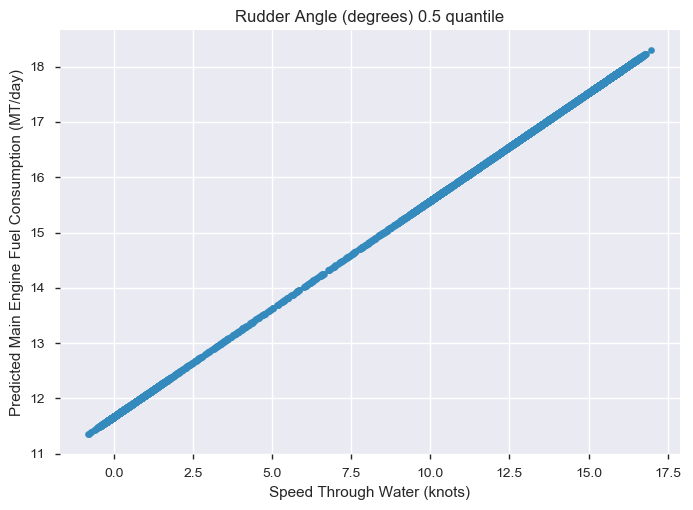

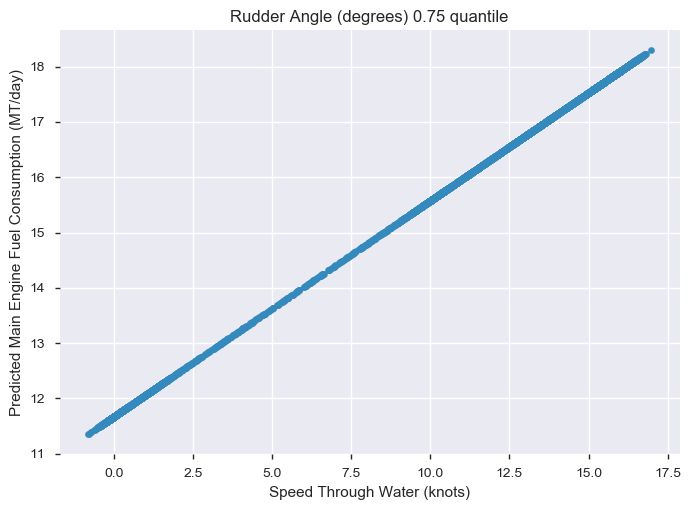

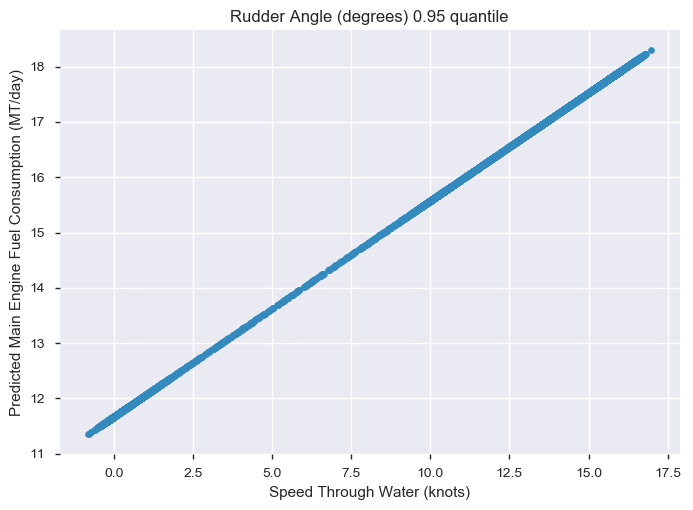

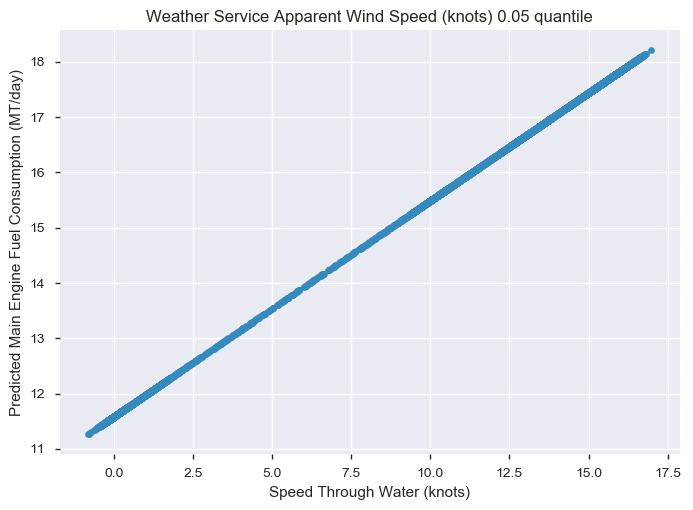

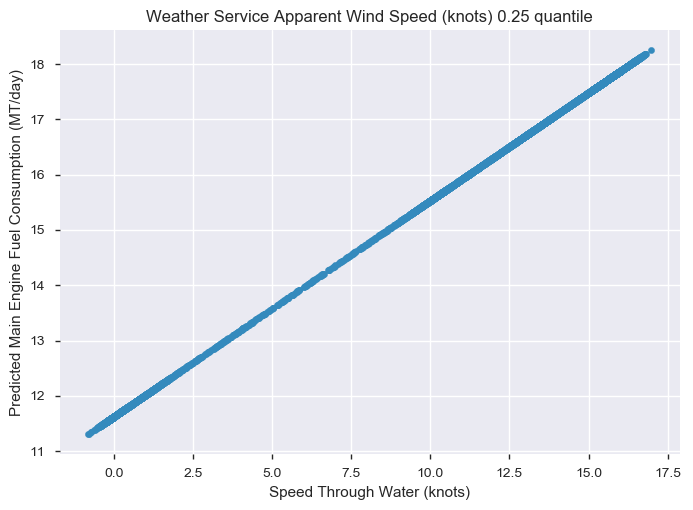

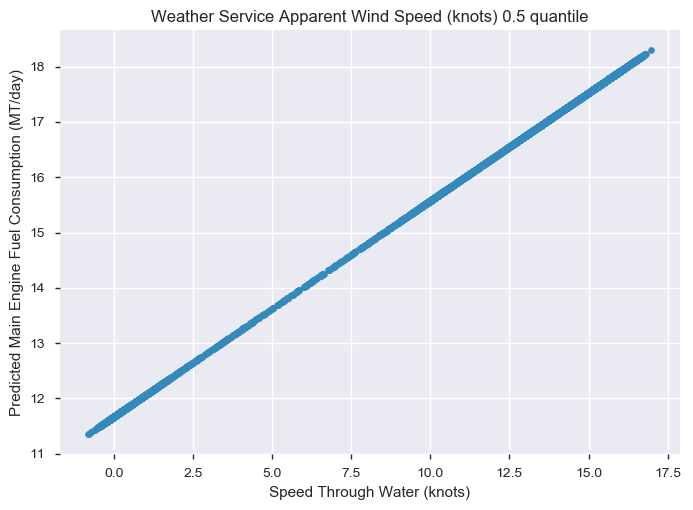

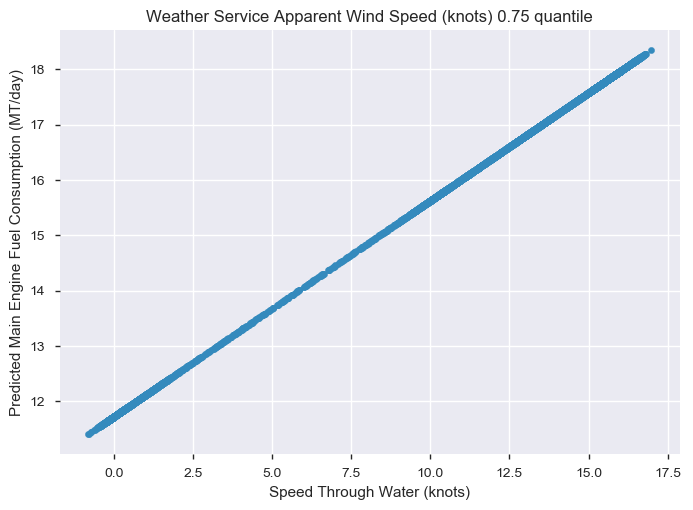

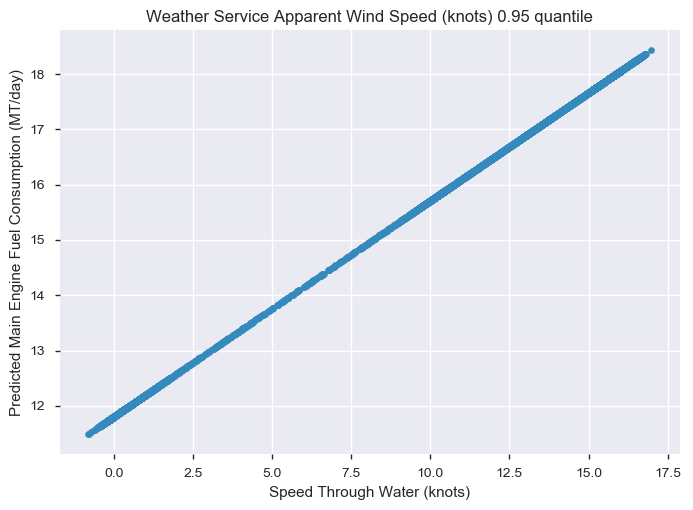

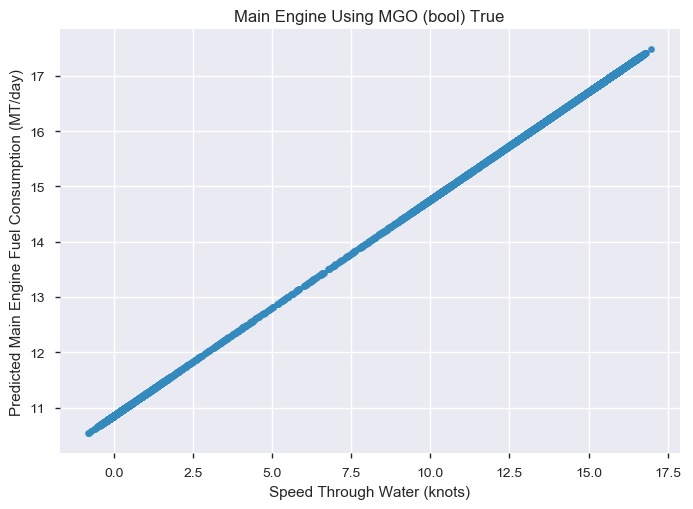

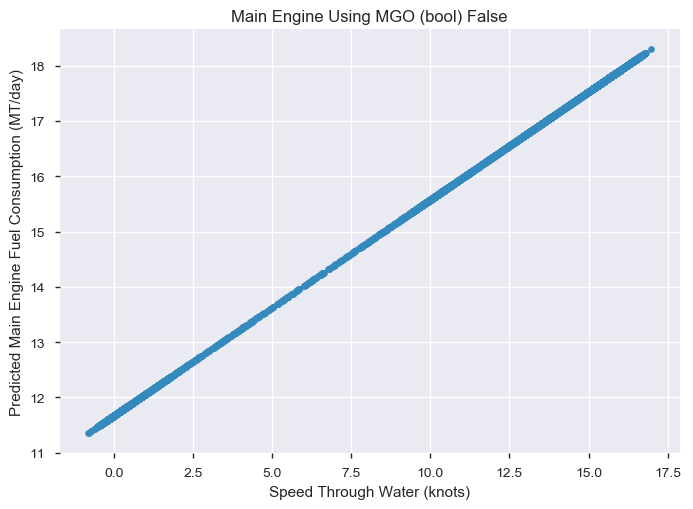

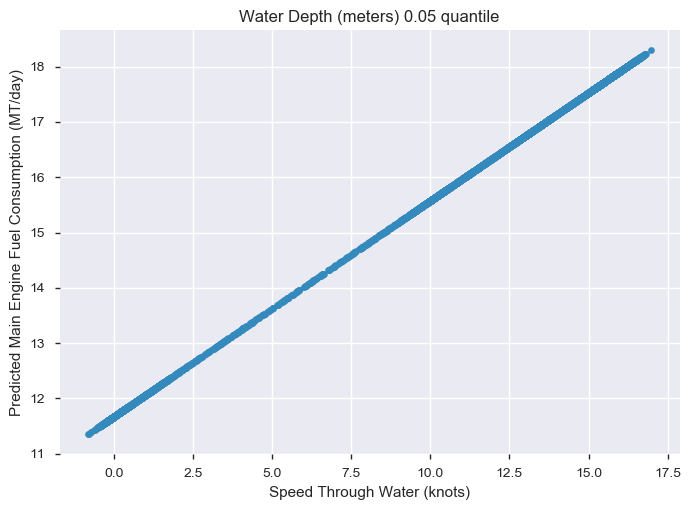

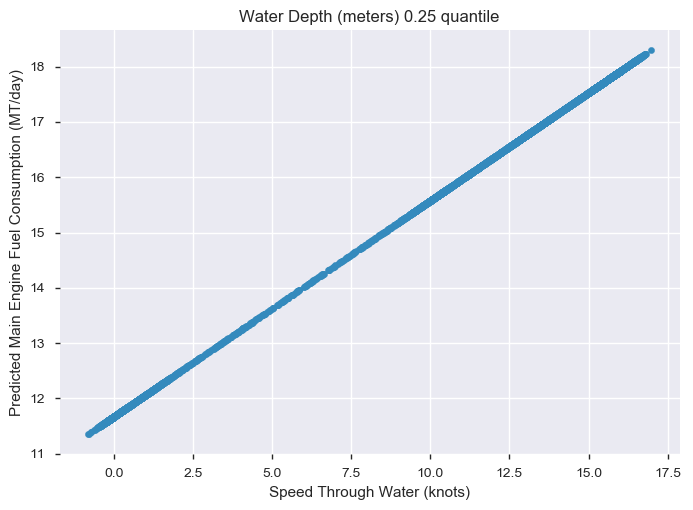

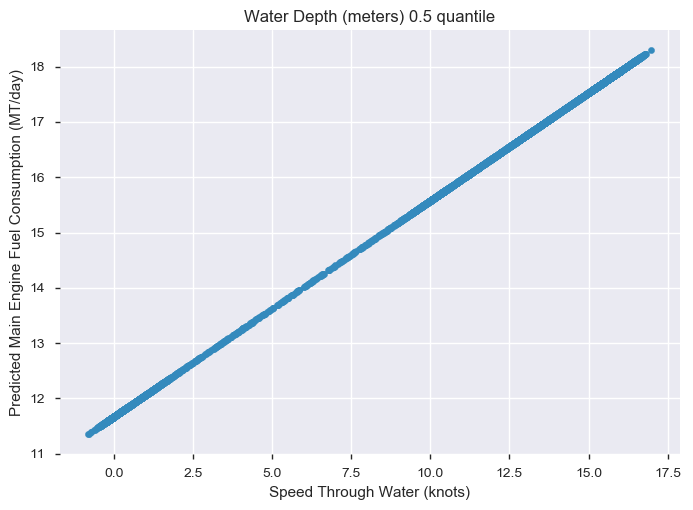

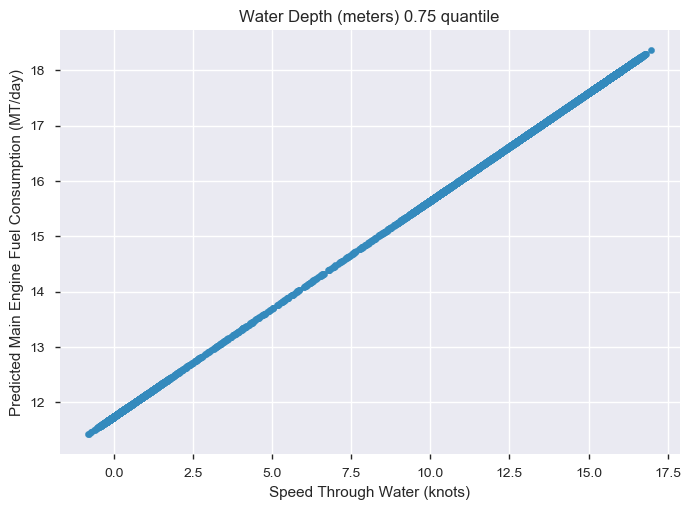

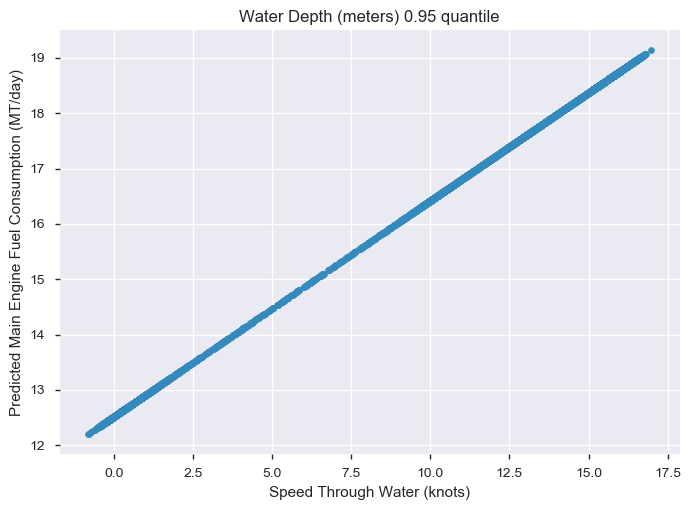

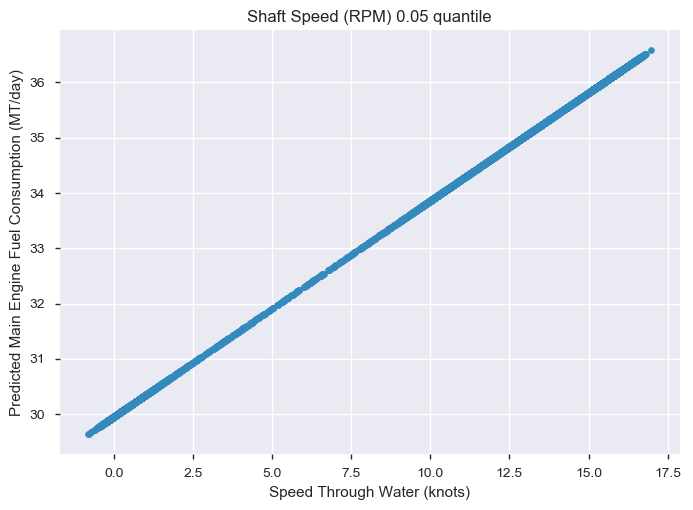

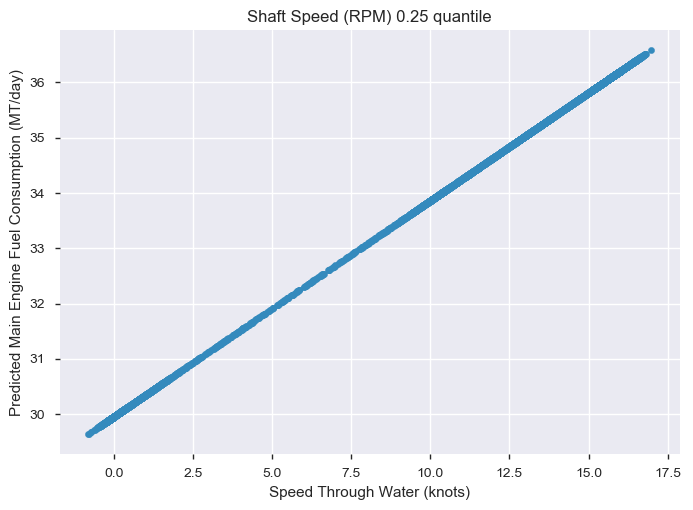

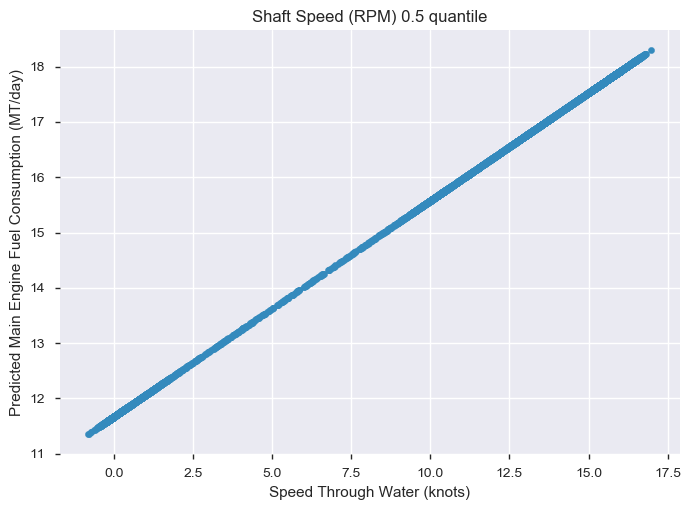

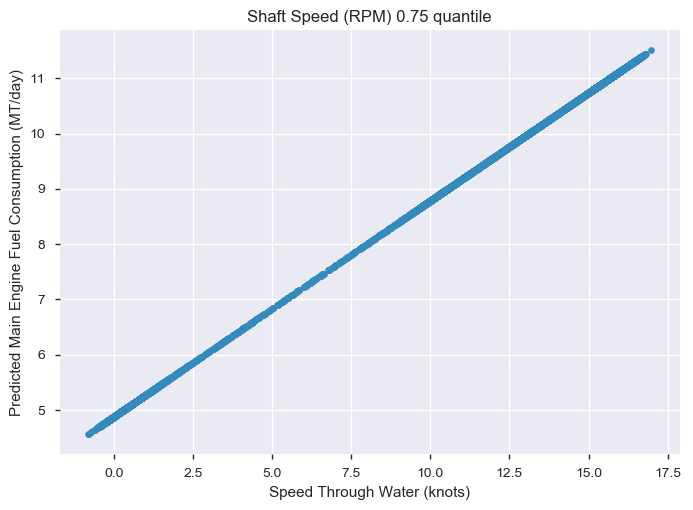

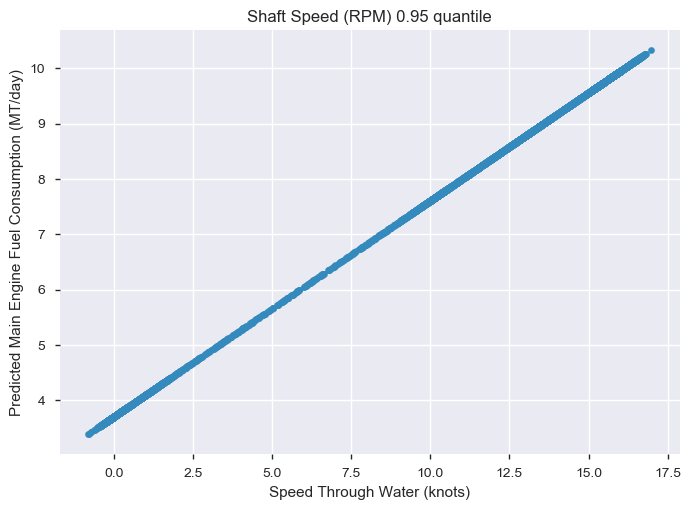

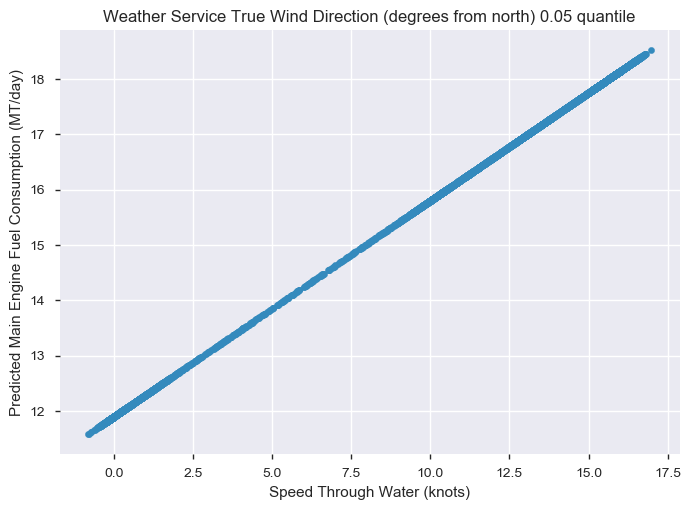

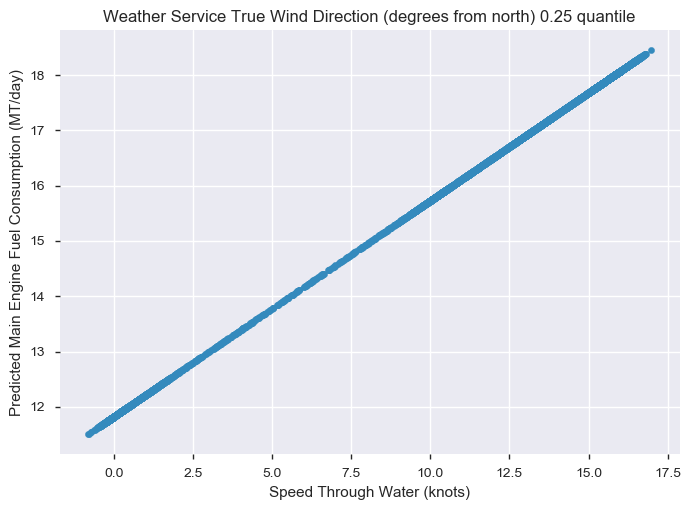

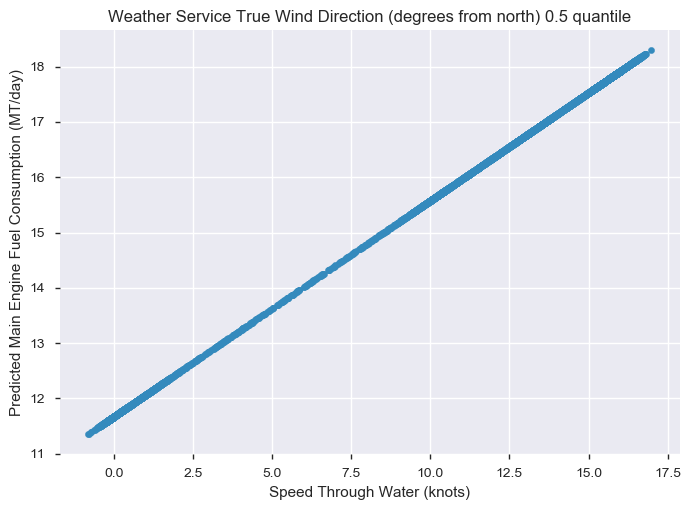

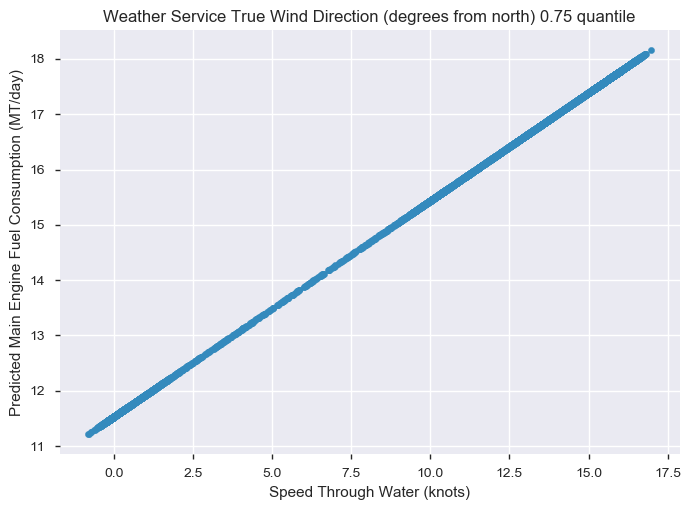

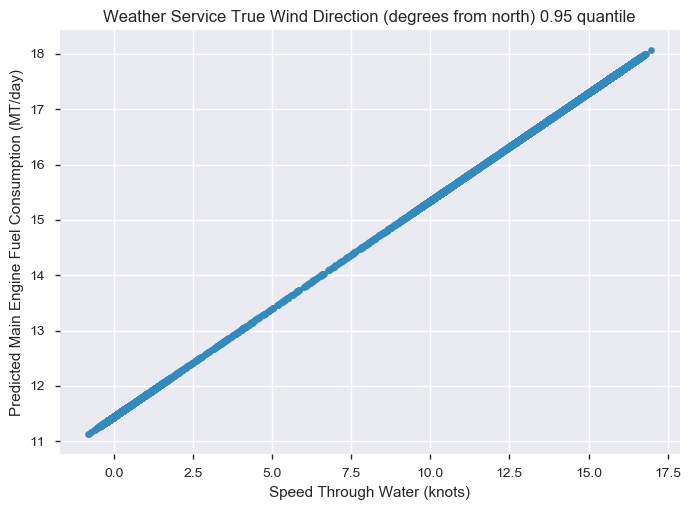

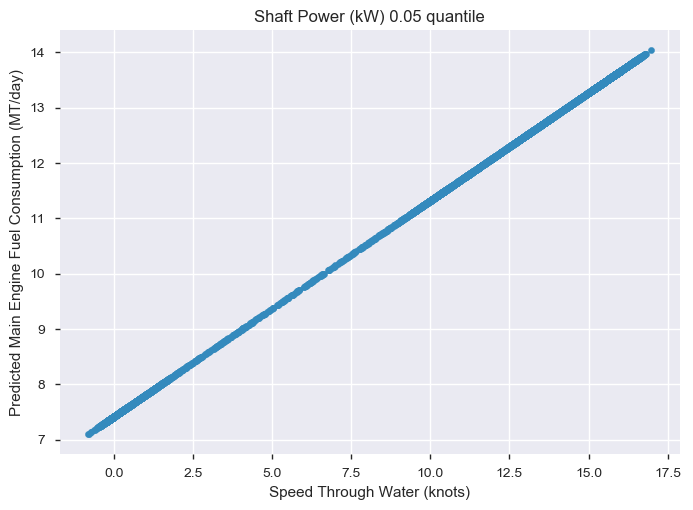

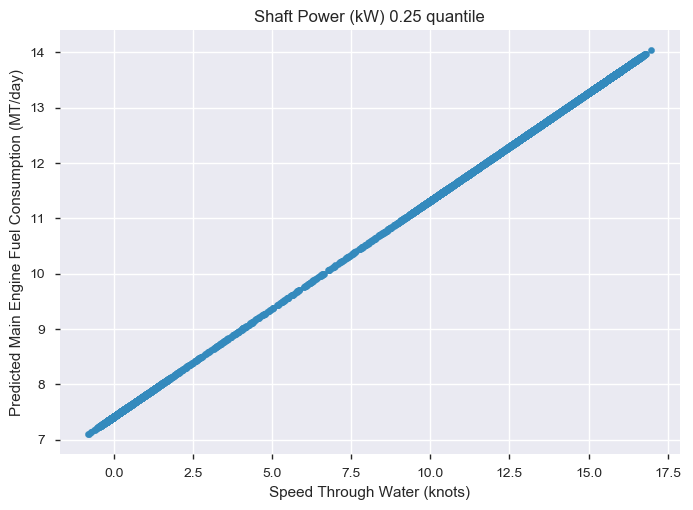

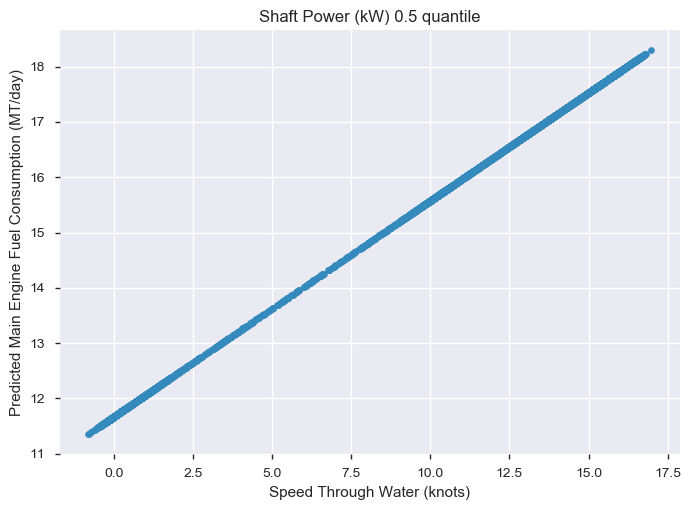

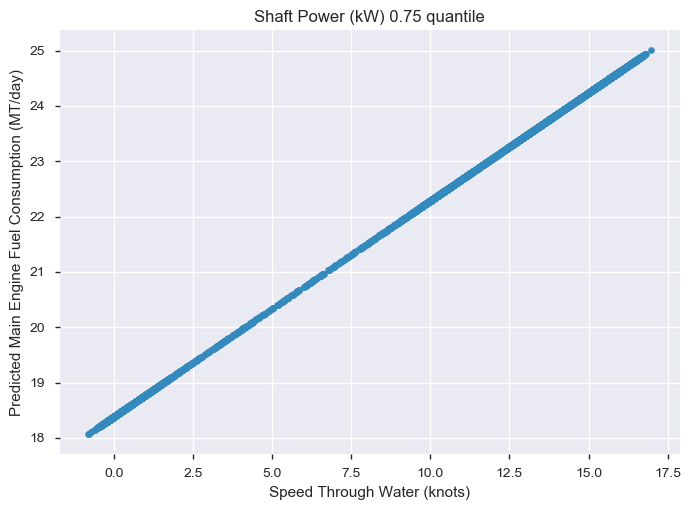

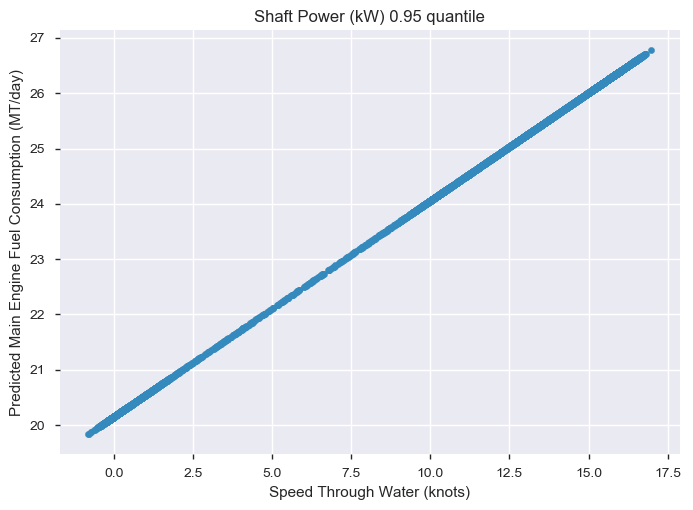

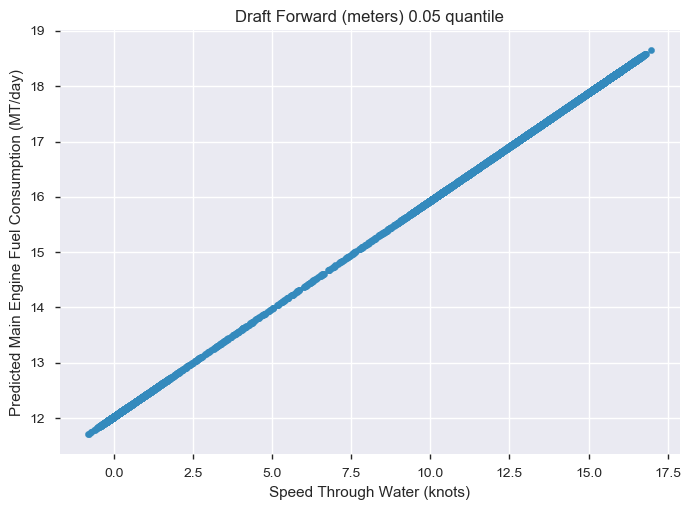

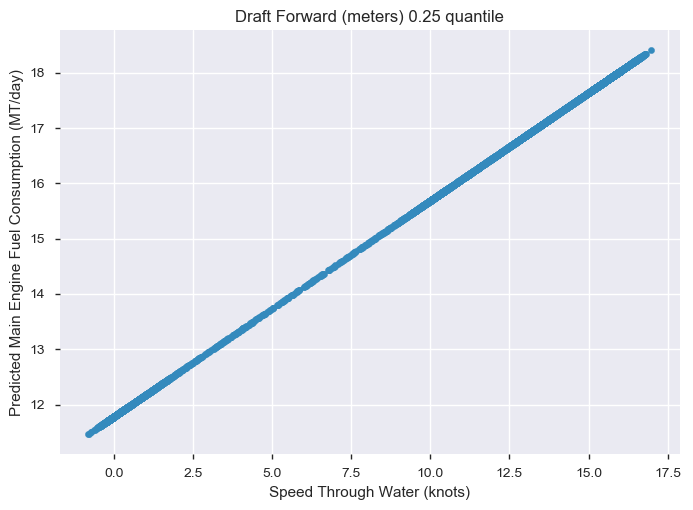

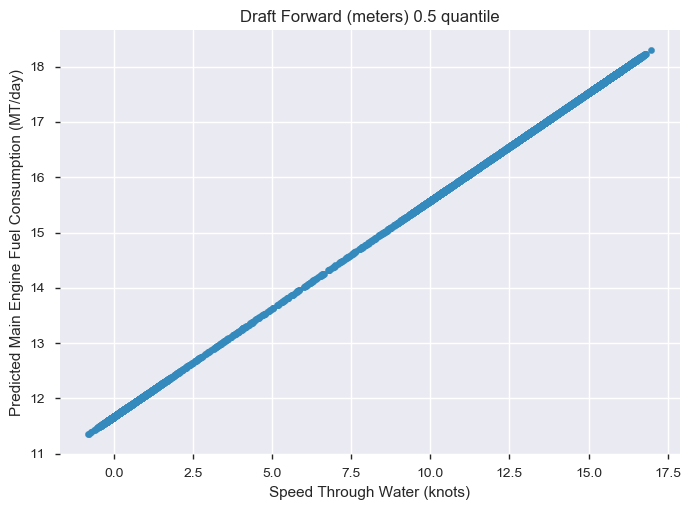

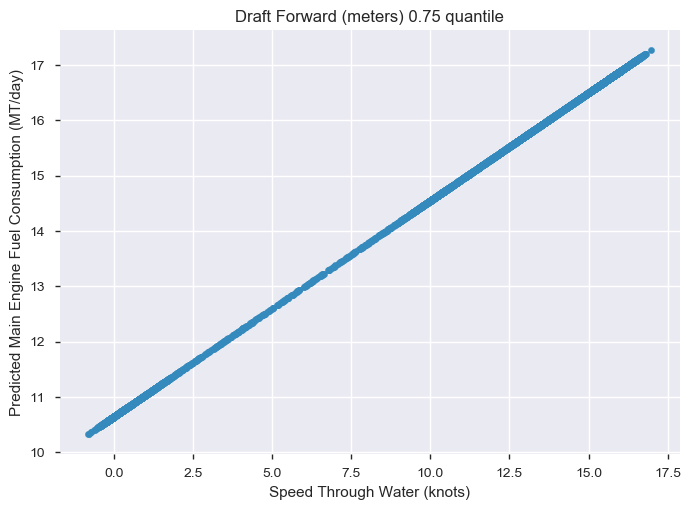

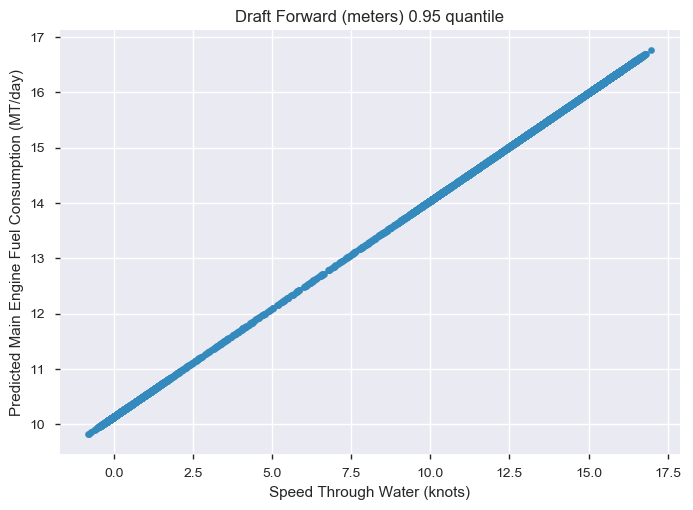

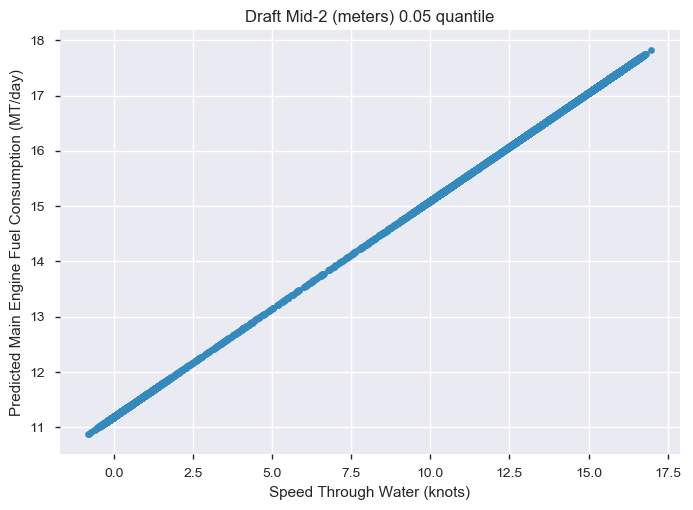

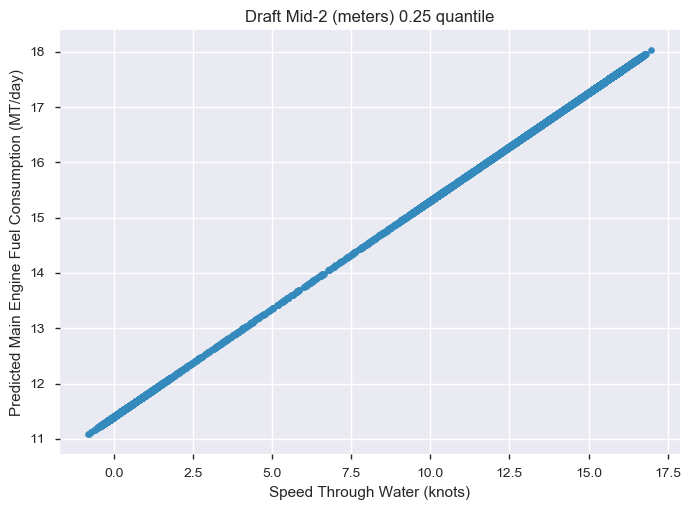

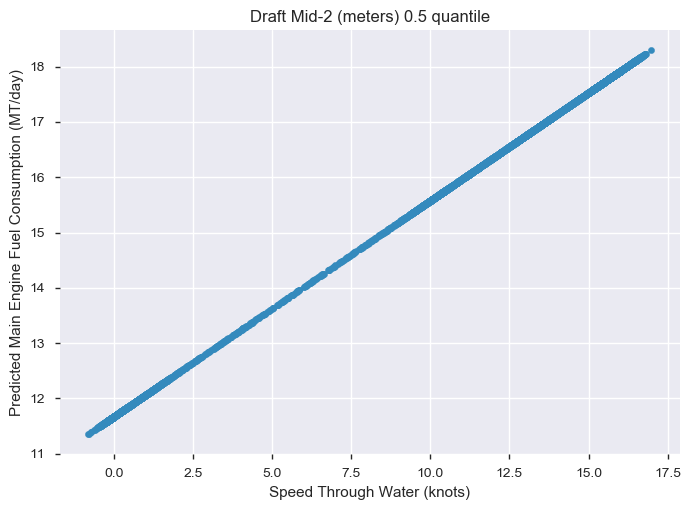

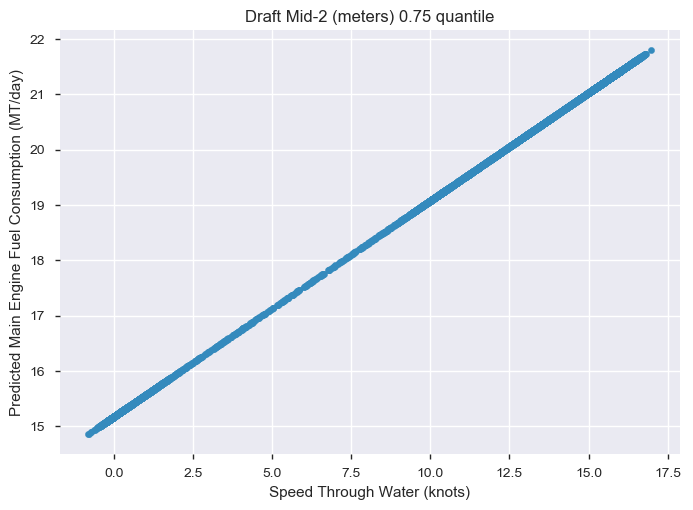

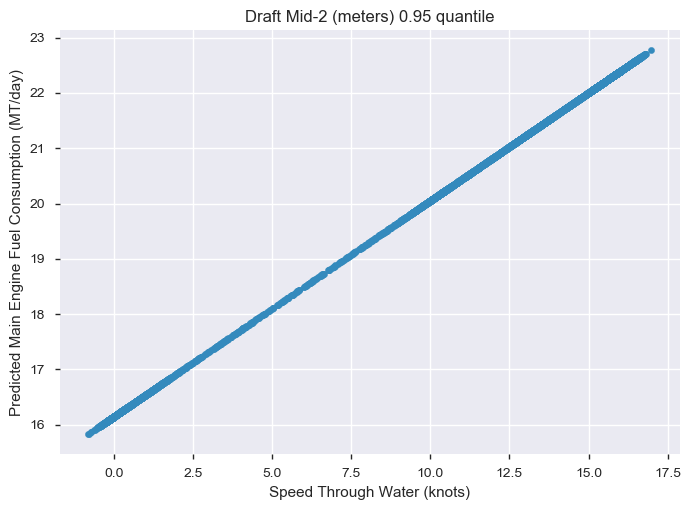

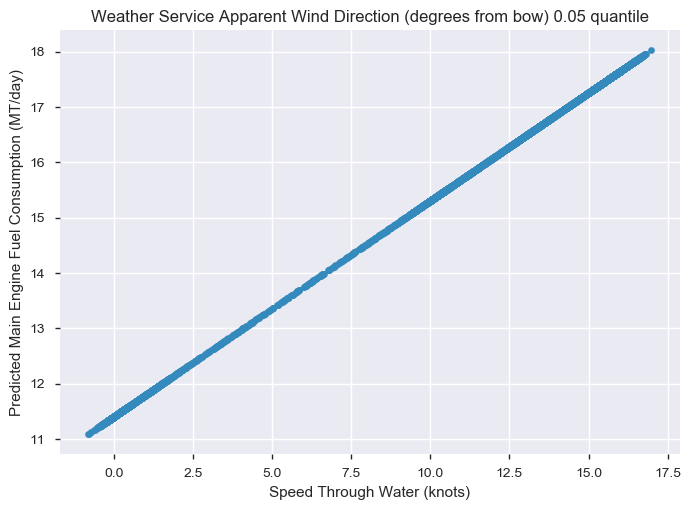

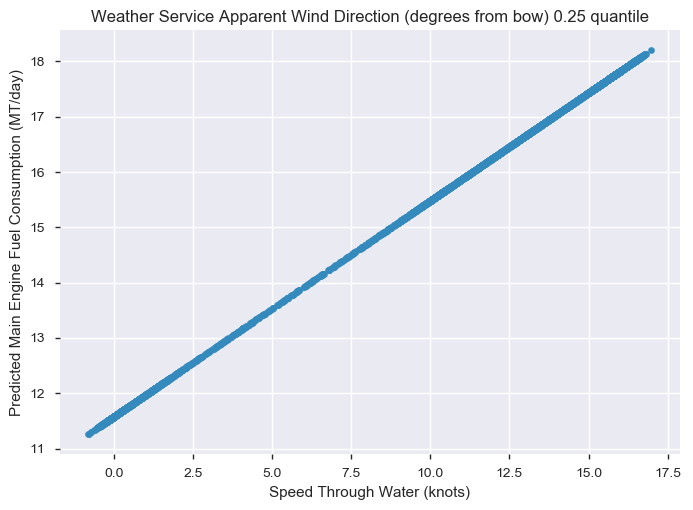

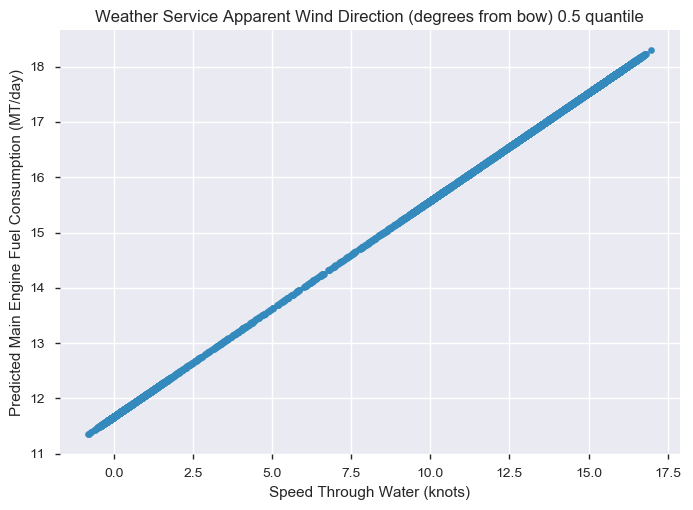

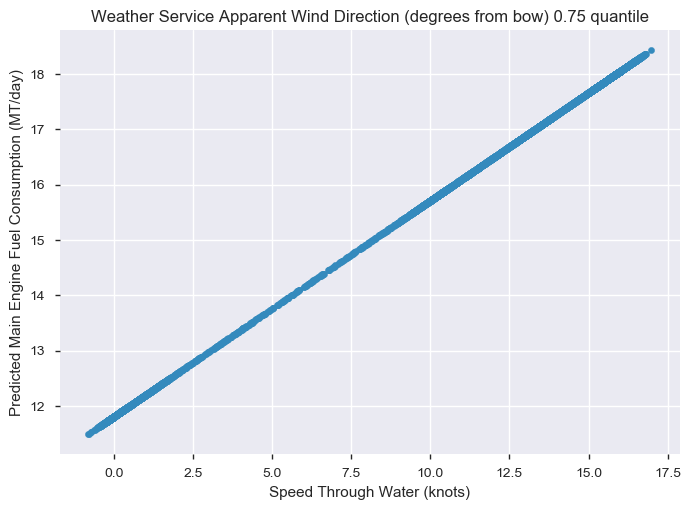

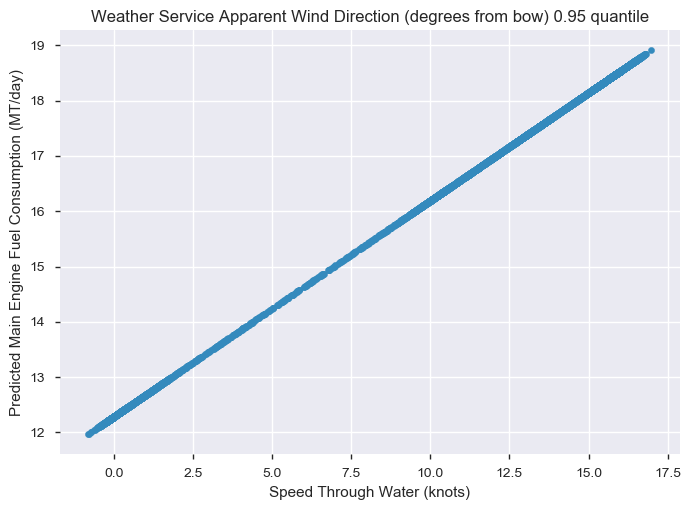

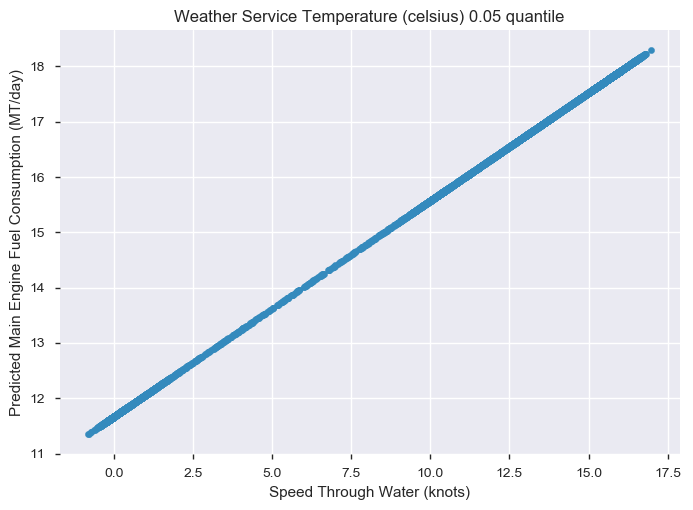

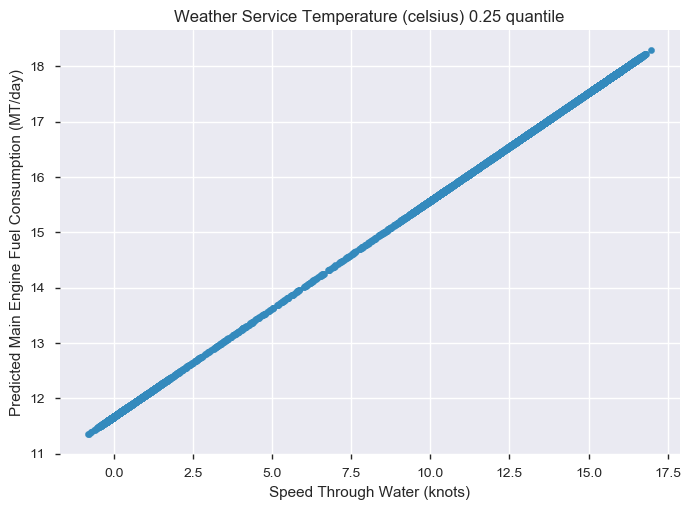

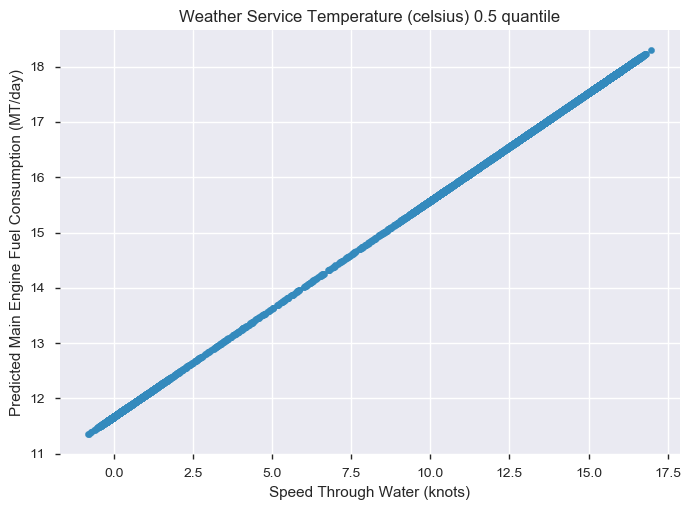

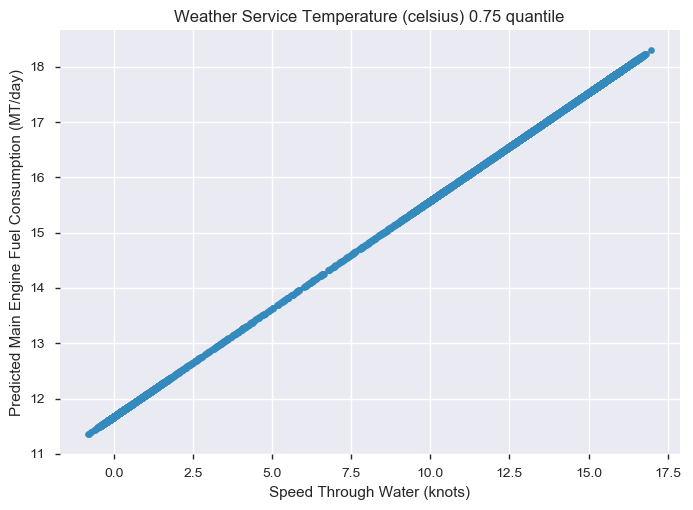

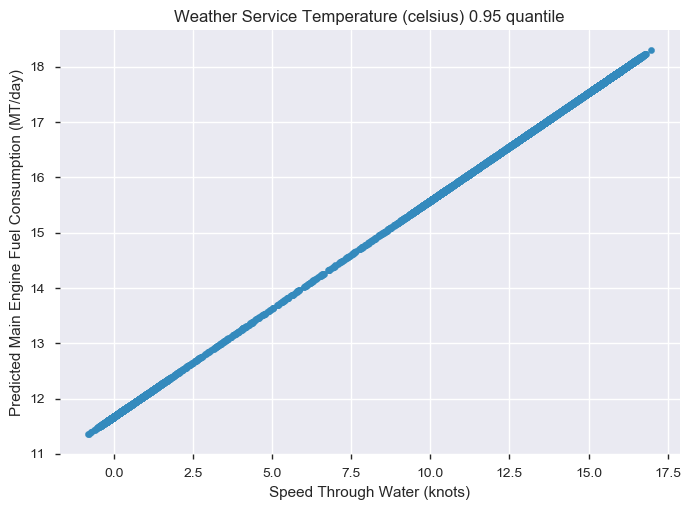

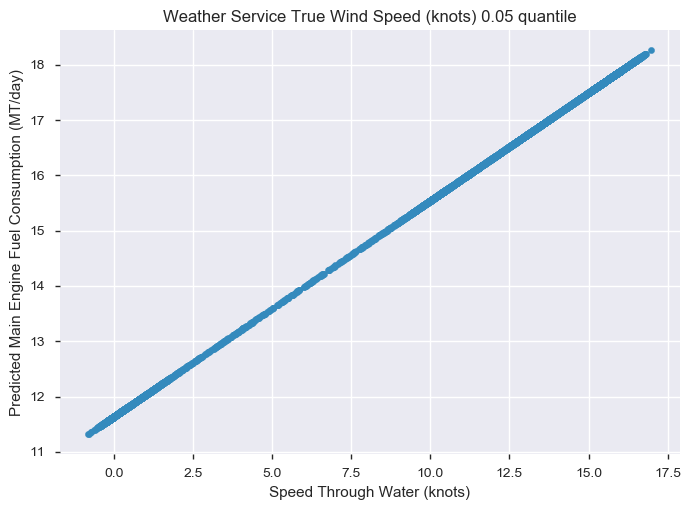

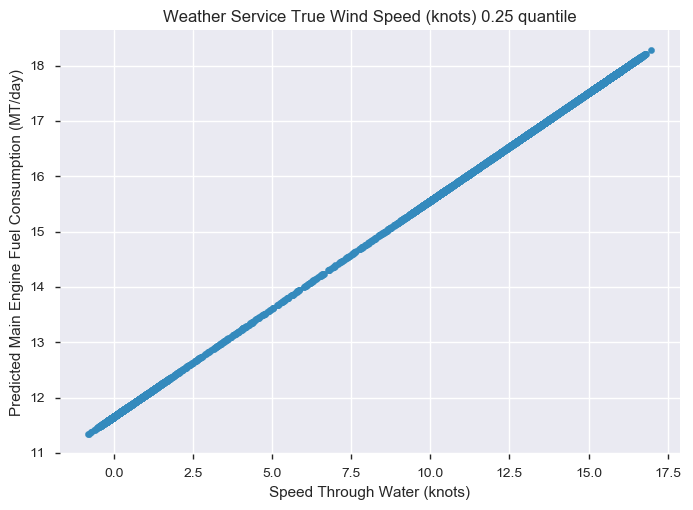

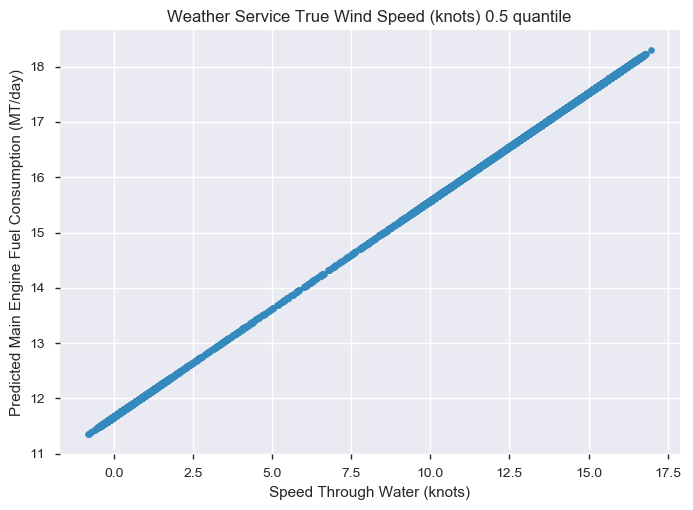

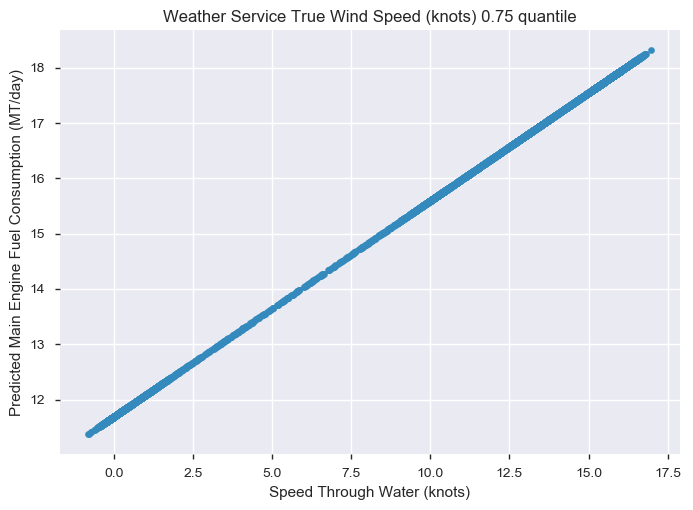

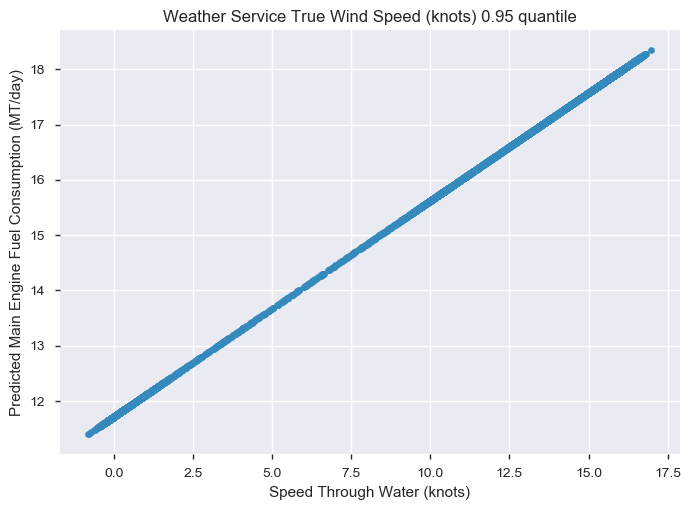

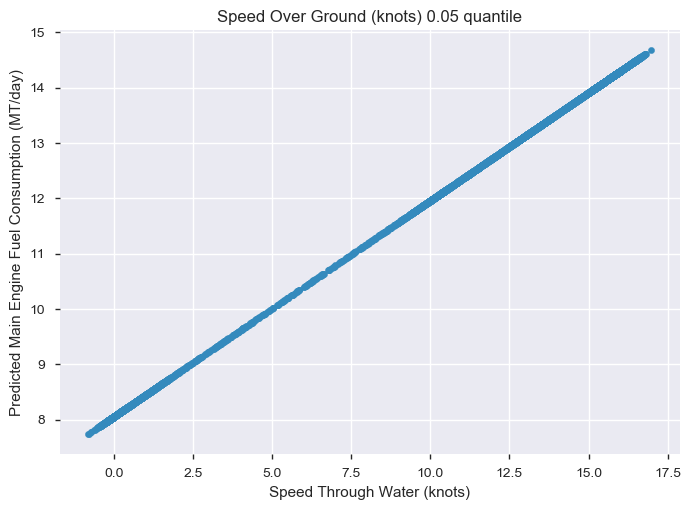

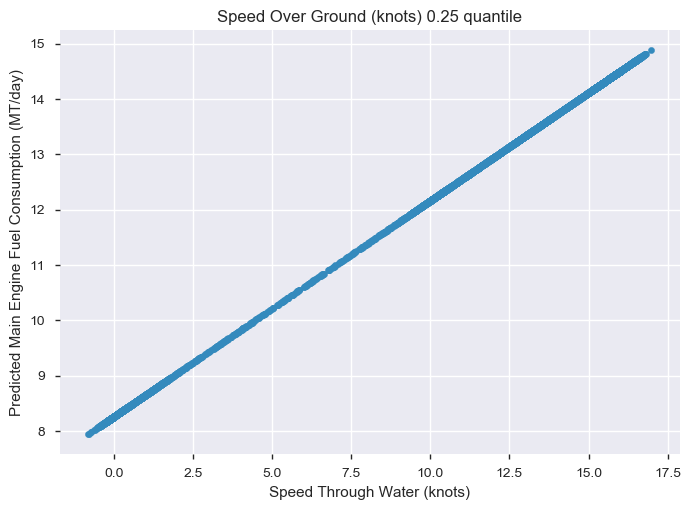

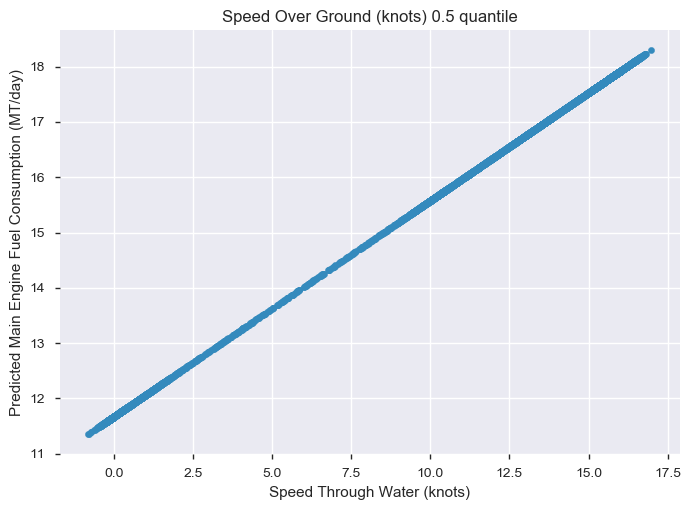

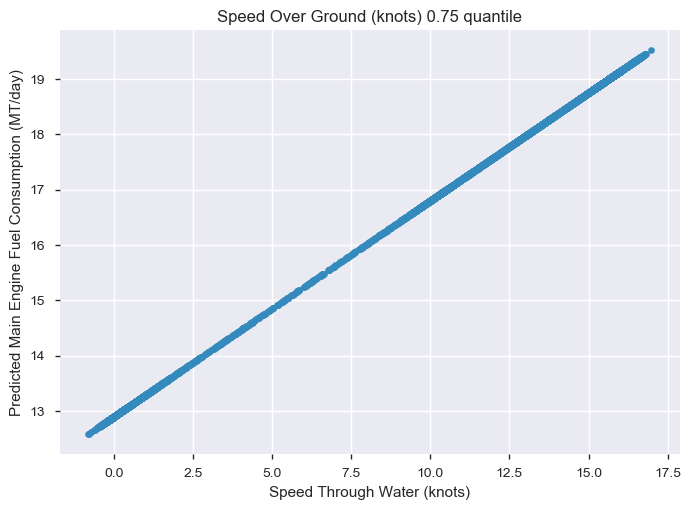

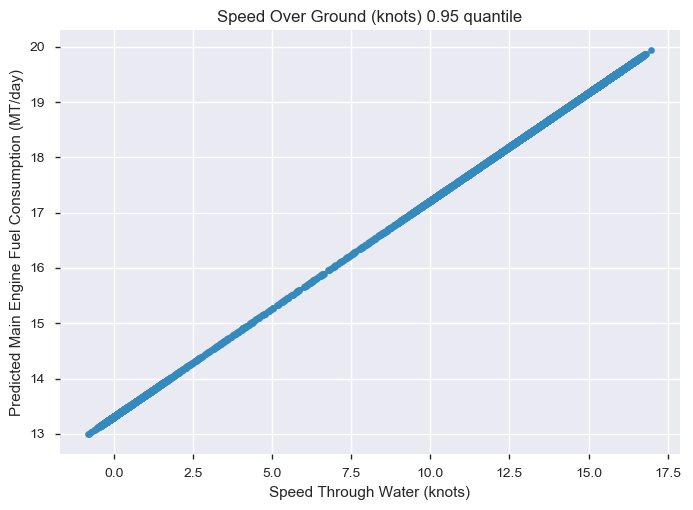

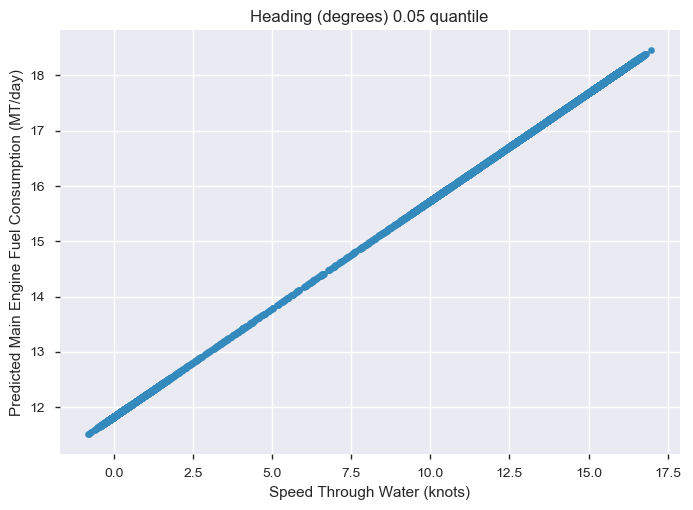

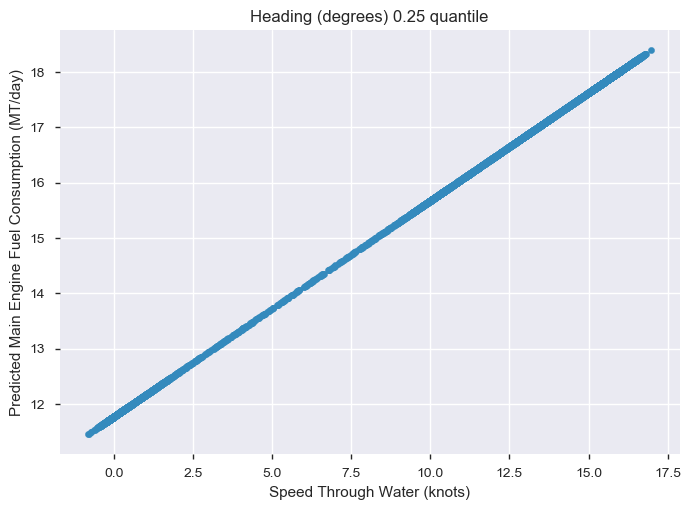

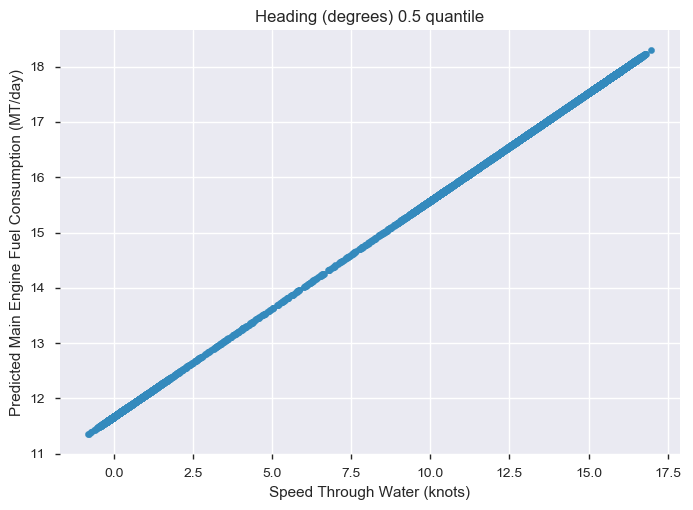

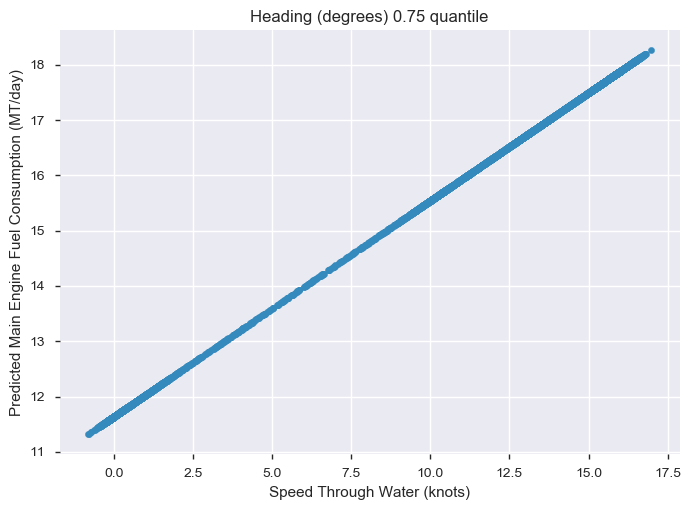

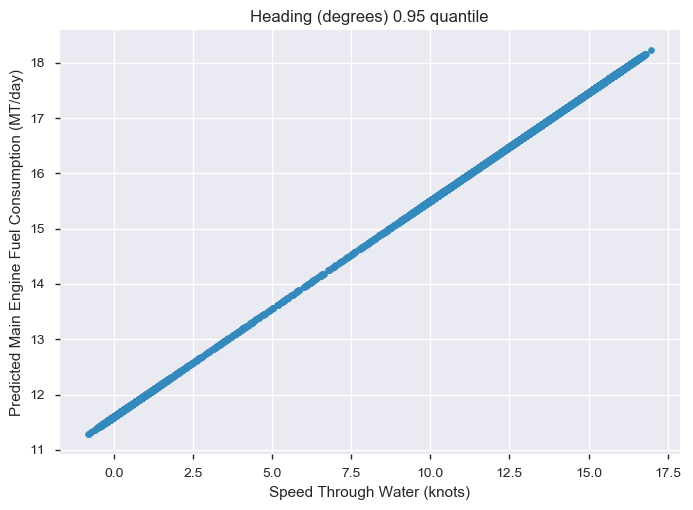

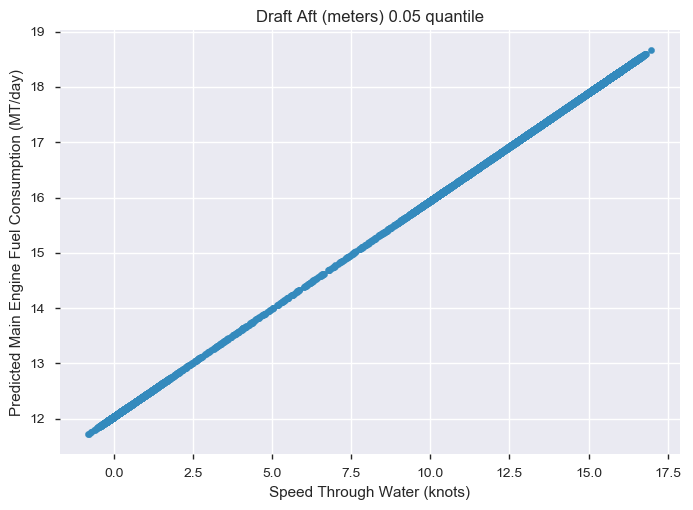

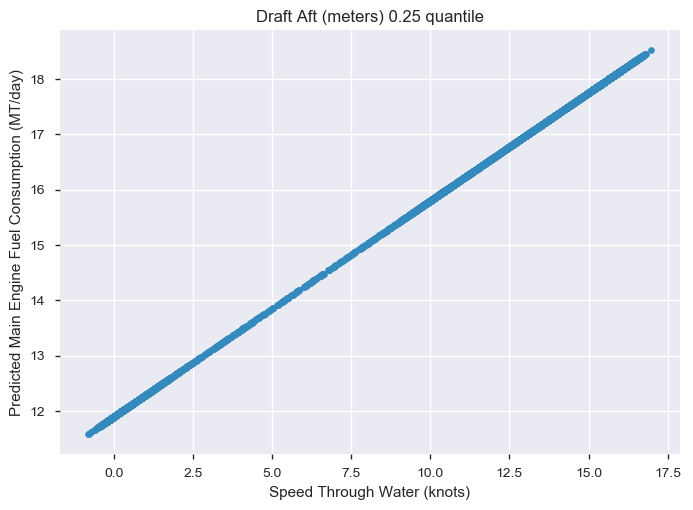

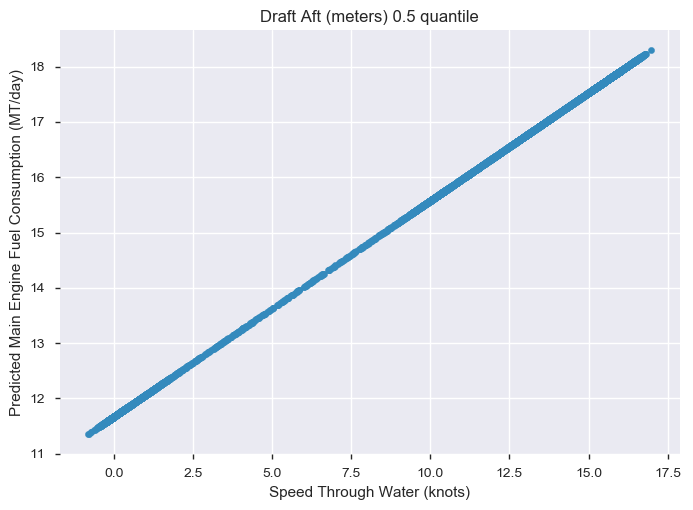

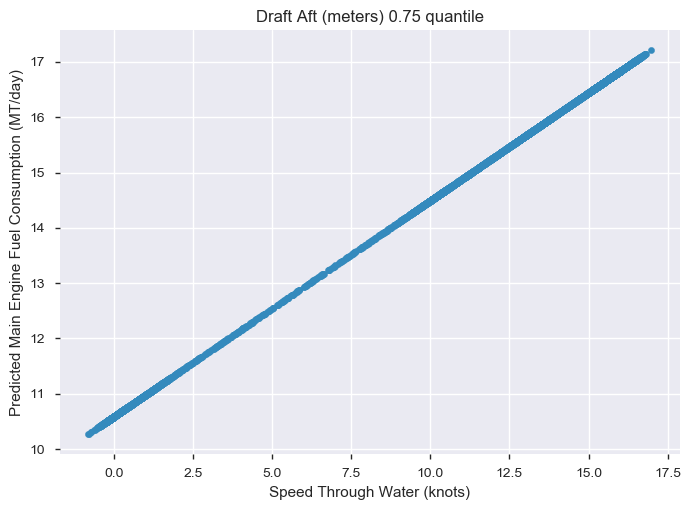

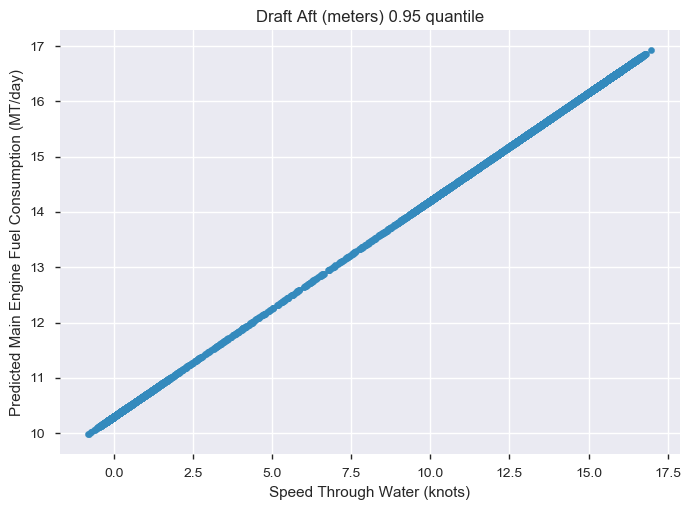

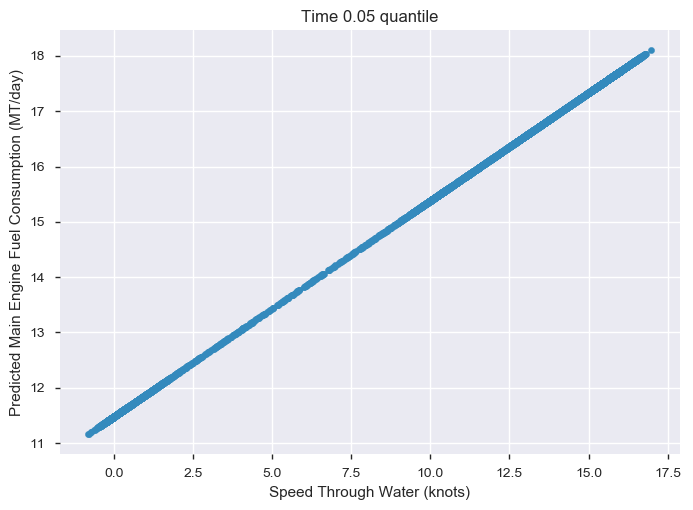

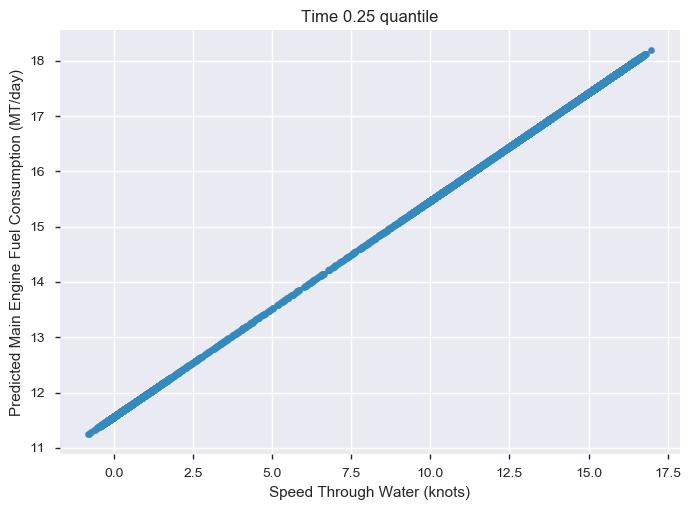

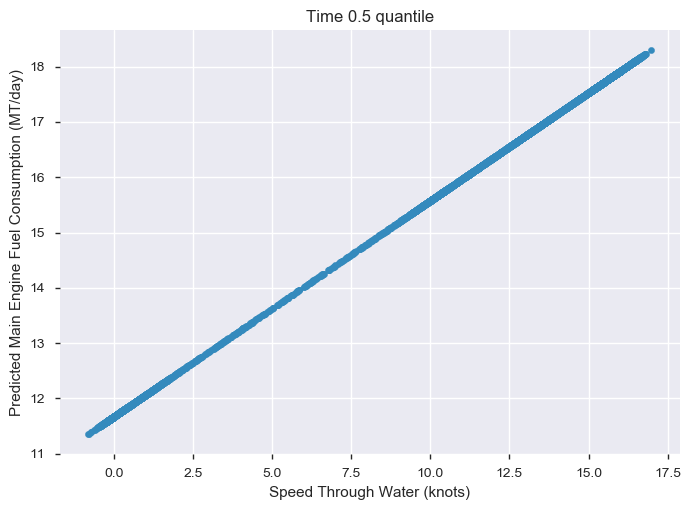

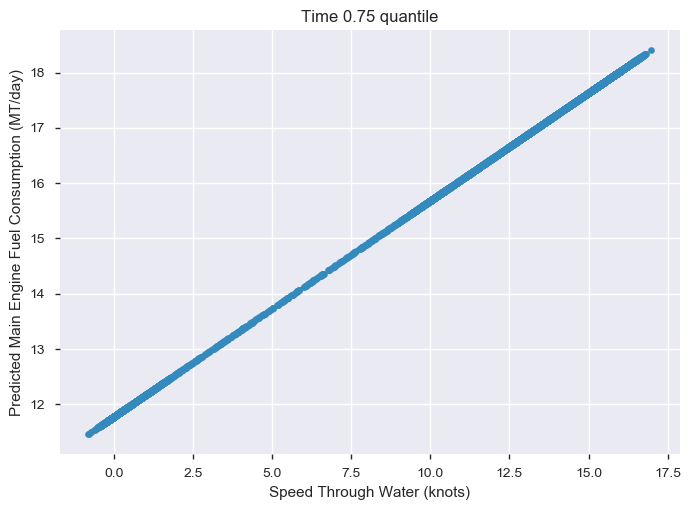

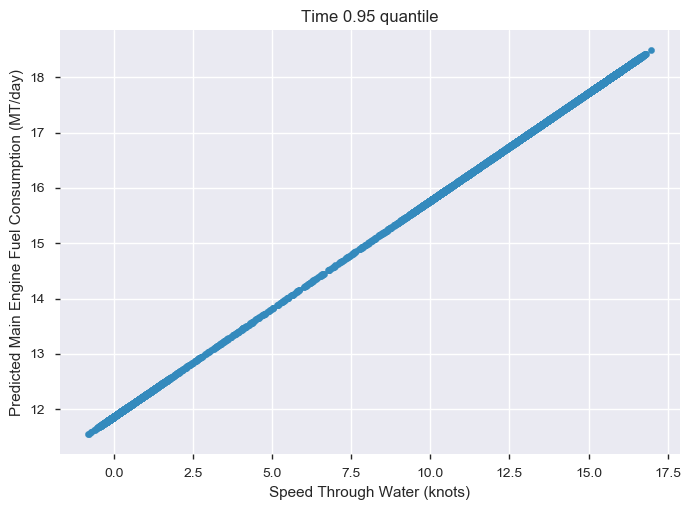

In [55]:
colset = set(X.columns)
colset.remove('Speed Through Water (knots)')
boolcols = {'Main Engine Using HFO (bool)', 'Main Engine Using MGO (bool)'}

for col in colset:
    subcolset = colset.copy()
    subcolset.remove(col)
    if col in boolcols:
        intlist = [1, 0]
        strlist = ['True', 'False']
        for i in range(len(intlist)):
            X_modded = X.copy()
            for subcol in subcolset:
                X_modded[subcol] = X_modded[subcol].median()
            X_modded[col] = intlist[i]
            y_pred = reg.predict(X_modded) # make new prediction
            df_pred = X_modded.copy()
            df_pred['Predicted Main Engine Fuel Consumption (MT/day)'] = y_pred
            df_pred.plot(x='Speed Through Water (knots)',
                         y='Predicted Main Engine Fuel Consumption (MT/day)', title=col+' '+strlist[i],
                         kind='scatter')
    else:
        quantilelist = [.05,.25,.5,.75,.95]
        for i in range(len(quantilelist)):
            X_modded = X.copy()
            for subcol in subcolset:
                X_modded[subcol] = X_modded[subcol].median()
            X_modded[col] = X_modded[col].quantile(quantilelist[i])
            y_pred = reg.predict(X_modded) # make new prediction
            df_pred = X_modded.copy()
            df_pred['Predicted Main Engine Fuel Consumption (MT/day)'] = y_pred
            print(col+' '+str(quantilelist[i])+' quantile = '+str(df_pred[col].quantile(quantilelist[i])))
            df_pred.plot(x='Speed Through Water (knots)',
                         y='Predicted Main Engine Fuel Consumption (MT/day)',
                         title=col+' '+str(quantilelist[i])+' quantile',
                         kind='scatter')

#         X_modded[col] = X_modded[col].median()
#         y_pred = reg.predict(X_modded)
#         df_pred = X_modded.copy()
#         df_pred['Predicted Main Engine Fuel Consumption (MT/day)'] = y_pred
#         df_pred.plot(x='Speed Through Water (knots)',
#                      y='Predicted Main Engine Fuel Consumption (MT/day)', title=col, kind='scatter')

In [27]:
alphas = np.logspace(-4, -1, 10)
scores = np.empty_like(alphas)
for i,a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    scores[i] = lasso.score(X_holdout, y_holdout)
    print(a, lasso.coef_)
    
lassocv = LassoCV()
lassocv.fit(X, y)
lassocv_score = lassocv.score(X, y)
lassocv_alpha = lassocv.alpha_
print('CV', lassocv.coef_)

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0001 [ 1.29399683e-08 -7.33060746e+00 -8.34597971e+00 -2.33477137e-01
 -1.12475697e-01  5.82229701e-03  5.67407995e-01 -2.85074675e-01
  3.89321696e-02  1.41435345e-03  3.06043339e-01  3.83640532e-01
 -8.05648634e-04  1.98981182e-04  1.13243644e-02  2.73302627e-03
  5.52030797e-03 -1.29841101e-03 -1.70889830e-04  5.78508942e-03]
0.00021544346900318845 [ 1.29416746e-08 -6.43430806e+00 -7.44074609e+00 -2.50168579e-01
 -1.50823918e-01 -8.54171482e-03  6.34523133e-01 -2.86605126e-01
  3.90608779e-02  1.40530317e-03  3.08886635e-01  3.86910880e-01
 -8.05669116e-04  2.27603742e-04  1.12152757e-02  2.72692694e-03
  5.27620170e-03 -1.31101768e-03 -1.18892134e-04  5.78860842e-03]


/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.00046415888336127773 [ 1.29727772e-08 -4.48935627e+00 -5.47747013e+00 -2.83178590e-01
 -2.29009552e-01 -4.86432280e-02  7.81269668e-01 -2.89840049e-01
  3.93332048e-02  1.38626356e-03  3.14555788e-01  3.94010776e-01
 -8.02589451e-04  2.92201855e-04  1.10015299e-02  2.71190109e-03
  4.79597088e-03 -1.33959863e-03 -9.57406718e-06  5.79578333e-03]
0.001 [ 1.30457266e-08 -3.05485911e-01 -1.25449263e+00 -3.53360573e-01
 -3.96012508e-01 -1.36709580e-01  1.09680456e+00 -2.96762819e-01
  3.99239261e-02  1.34499435e-03  3.26737779e-01  4.08933801e-01
 -7.95509447e-04  4.31882051e-04  1.05282817e-02  2.67954917e-03
  3.77614975e-03 -1.40125176e-03  2.21402550e-04  5.81125732e-03]
0.002154434690031882 [ 1.33194584e-08  0.00000000e+00 -9.42023884e-01 -3.36126849e-01
 -3.82066680e-01 -1.76097543e-01  1.10537629e+00 -2.99833306e-01
  4.03354092e-02  1.31908278e-03  3.24400154e-01  4.15941180e-01
 -7.83066460e-04  4.33057436e-04  1.03652218e-02  2.67464856e-03
  3.94120486e-03 -1.41027006e-03  2.34

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.004641588833612777 [ 1.31979317e-08  0.00000000e+00 -9.15078155e-01 -3.25819472e-01
 -3.86495768e-01 -1.66696730e-01  1.08549546e+00 -3.00045090e-01
  4.05923469e-02  1.30184120e-03  3.24210124e-01  4.11260736e-01
 -7.82774633e-04  4.24771034e-04  9.88670454e-03  2.68545556e-03
  3.97804330e-03 -1.40566982e-03  2.57352991e-04  5.78420701e-03]
0.01 [ 1.28799516e-08  0.00000000e+00 -8.55874816e-01 -3.04067094e-01
 -3.98074312e-01 -1.47371161e-01  1.04551105e+00 -2.99679860e-01
  4.10646187e-02  1.26983202e-03  3.24060496e-01  3.98857056e-01
 -7.81279643e-04  4.11516450e-04  8.86134222e-03  2.70824357e-03
  4.06456161e-03 -1.39574189e-03  3.05010457e-04  5.75724360e-03]


/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.021544346900318822 [ 1.21933330e-08  0.00000000e+00 -7.28283007e-01 -2.57226634e-01
 -4.23084235e-01 -1.05731323e-01  9.59438426e-01 -2.98875010e-01
  4.20800395e-02  1.20099852e-03  3.23799874e-01  3.72037237e-01
 -7.78026349e-04  3.83079091e-04  6.65304703e-03  2.75729878e-03
  4.25117383e-03 -1.37432774e-03  4.07664875e-04  5.69917788e-03]
0.046415888336127774 [ 1.07139162e-08  0.00000000e+00 -4.53367173e-01 -1.56372642e-01
 -4.77026191e-01 -1.58847446e-02  7.73991239e-01 -2.97154660e-01
  4.42679692e-02  1.05268000e-03  3.23333896e-01  3.14230427e-01
 -7.71025557e-04  3.21748542e-04  1.89758835e-03  2.86293493e-03
  4.65266008e-03 -1.32813969e-03  6.28858290e-04  5.57403226e-03]
0.1 [ 8.34084943e-09  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -3.98621855e-01 -0.00000000e+00  4.79487420e-01 -2.94948420e-01
  4.82726581e-02  7.73043271e-04  3.16325437e-01  2.16178326e-01
 -7.32100384e-04  2.70244065e-04 -3.11644052e-04  3.15020438e-03
  3.78690998e-04 -1.23682188e-03  1.161736

/Users/etheredgej/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [ ]:
# This script creates a ton of features, then trains an ensemble of XGBoost 
# regressor, Lasso regressor, ElasticNet and KernelRidge.
#
# It borrows ideas from lots of other people's scripts, including:
# https://www.kaggle.com/humananalog/house-prices-advanced-regression-techniques/xgboost-lasso
# https://www.kaggle.com/klyusba/house-prices-advanced-regression-techniques/lasso-model-for-regression-problem/notebook
# https://www.kaggle.com/juliencs/house-prices-advanced-regression-techniques/a-study-on-regression-applied-to-the-ames-dataset/
# https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

import datetime
import numpy as np
import pandas as pd

# The error metric: RMSE on the log of the sale prices.
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew

start_time = datetime.datetime.now()

################################################################################
class CustomEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regressors=None):
        self.regressors = regressors

    def fit(self, X, y):
        for regressor in self.regressors:
            regressor.fit(X, y)

    def predict(self, X):
        self.predictions_ = list()
        for regressor in self.regressors:
            self.predictions_.append(np.exp(regressor.predict(X).ravel()))

        return np.log1p(np.mean(self.predictions_, axis=0))
        
################################################################################
# RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def factorize(df, factor_df, column, fill_na=None):
    factor_df[column] = df[column]
    if fill_na is not None:
        factor_df[column].fillna(fill_na, inplace=True)
    le.fit(factor_df[column].unique())
    factor_df[column] = le.transform(factor_df[column])
    return factor_df

# Combine all the (numerical) features into one big DataFrame. We don't add 
# the one-hot encoded variables here yet, that happens later on.
def munge(df):
    all_df = pd.DataFrame(index = df.index)
   
    all_df['LotFrontage'] = df['LotFrontage']   
    for key, group in lot_frontage_by_neighborhood:
        idx = (df['Neighborhood'] == key) & (df['LotFrontage'].isnull())
        all_df.loc[idx, 'LotFrontage'] = group.median()    

    all_df['LotArea'] = df['LotArea']

    all_df['MasVnrArea'] = df['MasVnrArea']
    all_df['MasVnrArea'].fillna(0, inplace=True)
   
    all_df['BsmtFinSF1'] = df['BsmtFinSF1']
    all_df['BsmtFinSF1'].fillna(0, inplace=True)

    all_df['BsmtFinSF2'] = df['BsmtFinSF2']
    all_df['BsmtFinSF2'].fillna(0, inplace=True)

    all_df['BsmtUnfSF'] = df['BsmtUnfSF']
    all_df['BsmtUnfSF'].fillna(0, inplace=True)

    all_df['TotalBsmtSF'] = df['TotalBsmtSF']
    all_df['TotalBsmtSF'].fillna(0, inplace=True)

    all_df['1stFlrSF'] = df['1stFlrSF']
    all_df['2ndFlrSF'] = df['2ndFlrSF']
    all_df['GrLivArea'] = df['GrLivArea']
    
    all_df['GarageArea'] = df['GarageArea']
    all_df['GarageArea'].fillna(0, inplace=True)

    all_df['WoodDeckSF'] = df['WoodDeckSF']
    all_df['OpenPorchSF'] = df['OpenPorchSF']
    all_df['EnclosedPorch'] = df['EnclosedPorch']
    all_df['3SsnPorch'] = df['3SsnPorch']
    all_df['ScreenPorch'] = df['ScreenPorch']
    
    all_df['BsmtFullBath'] = df['BsmtFullBath']
    all_df['BsmtFullBath'].fillna(0, inplace=True)

    all_df['BsmtHalfBath'] = df['BsmtHalfBath']
    all_df['BsmtHalfBath'].fillna(0, inplace=True)

    all_df['FullBath'] = df['FullBath'] 
    all_df['HalfBath'] = df['HalfBath'] 
    all_df['BedroomAbvGr'] = df['BedroomAbvGr'] 
    all_df['KitchenAbvGr'] = df['KitchenAbvGr'] 
    all_df['TotRmsAbvGrd'] = df['TotRmsAbvGrd'] 
    all_df['Fireplaces'] = df['Fireplaces'] 

    all_df['GarageCars'] = df['GarageCars']
    all_df['GarageCars'].fillna(0, inplace=True)

    all_df['CentralAir'] = (df['CentralAir'] == 'Y') * 1.0
   
    all_df['OverallQual'] = df['OverallQual']
    all_df['OverallCond'] = df['OverallCond']

    # Quality measurements are stored as text but we can convert them to 
    # numbers where a higher number means higher quality.

    qual_dict = {None: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    all_df['ExterQual'] = df['ExterQual'].map(qual_dict).astype(int)
    all_df['ExterCond'] = df['ExterCond'].map(qual_dict).astype(int)
    all_df['BsmtQual'] = df['BsmtQual'].map(qual_dict).astype(int)
    all_df['BsmtCond'] = df['BsmtCond'].map(qual_dict).astype(int)
    all_df['HeatingQC'] = df['HeatingQC'].map(qual_dict).astype(int)
    all_df['KitchenQual'] = df['KitchenQual'].map(qual_dict).astype(int)
    all_df['FireplaceQu'] = df['FireplaceQu'].map(qual_dict).astype(int)
    all_df['GarageQual'] = df['GarageQual'].map(qual_dict).astype(int)
    all_df['GarageCond'] = df['GarageCond'].map(qual_dict).astype(int)

    all_df['BsmtExposure'] = df['BsmtExposure'].map(
        {None: 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}).astype(int)

    bsmt_fin_dict = {None: 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
    all_df['BsmtFinType1'] = df['BsmtFinType1'].map(bsmt_fin_dict).astype(int)
    all_df['BsmtFinType2'] = df['BsmtFinType2'].map(bsmt_fin_dict).astype(int)

    all_df['Functional'] = df['Functional'].map(
        {None: 0, 'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 
         'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}).astype(int)

    all_df['GarageFinish'] = df['GarageFinish'].map(
        {None: 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}).astype(int)

    all_df['Fence'] = df['Fence'].map(
        {None: 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}).astype(int)

    all_df['YearBuilt'] = df['YearBuilt']
    all_df['YearRemodAdd'] = df['YearRemodAdd']

    all_df['GarageYrBlt'] = df['GarageYrBlt']
    all_df['GarageYrBlt'].fillna(0.0, inplace=True)

    all_df['MoSold'] = df['MoSold']
    all_df['YrSold'] = df['YrSold']
    
    all_df['LowQualFinSF'] = df['LowQualFinSF']
    all_df['MiscVal'] = df['MiscVal']

    all_df['PoolQC'] = df['PoolQC'].map(qual_dict).astype(int)

    all_df['PoolArea'] = df['PoolArea']
    all_df['PoolArea'].fillna(0, inplace=True)
    
    # Add categorical features as numbers too. It seems to help a bit.
    all_df = factorize(df, all_df, 'MSSubClass')
    all_df = factorize(df, all_df, 'MSZoning', 'RL')
    all_df = factorize(df, all_df, 'LotConfig')
    all_df = factorize(df, all_df, 'Neighborhood')
    all_df = factorize(df, all_df, 'Condition1')
    all_df = factorize(df, all_df, 'BldgType')
    all_df = factorize(df, all_df, 'HouseStyle')
    all_df = factorize(df, all_df, 'RoofStyle')
    all_df = factorize(df, all_df, 'Exterior1st', 'Other')
    all_df = factorize(df, all_df, 'Exterior2nd', 'Other')
    all_df = factorize(df, all_df, 'MasVnrType', 'None')
    all_df = factorize(df, all_df, 'Foundation')
    all_df = factorize(df, all_df, 'SaleType', 'Oth')
    all_df = factorize(df, all_df, 'SaleCondition')

    # IR2 and IR3 don't appear that often, so just make a distinction
    # between regular and irregular.
    all_df['IsRegularLotShape'] = (df['LotShape'] == 'Reg') * 1

    # Most properties are level; bin the other possibilities together
    # as 'not level'.
    all_df['IsLandLevel'] = (df['LandContour'] == 'Lvl') * 1

    # Most land slopes are gentle; treat the others as 'not gentle'.
    all_df['IsLandSlopeGentle'] = (df['LandSlope'] == 'Gtl') * 1

    # Most properties use standard circuit breakers.
    all_df['IsElectricalSBrkr'] = (df['Electrical'] == 'SBrkr') * 1

    # About 2/3rd have an attached garage.
    all_df['IsGarageDetached'] = (df['GarageType'] == 'Detchd') * 1

    # Most have a paved drive. Treat dirt/gravel and partial pavement
    # as 'not paved'.
    all_df['IsPavedDrive'] = (df['PavedDrive'] == 'Y') * 1

    # The only interesting 'misc. feature' is the presence of a shed.
    all_df['HasShed'] = (df['MiscFeature'] == 'Shed') * 1.  

    # If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
    all_df['Remodeled'] = (all_df['YearRemodAdd'] != all_df['YearBuilt']) * 1
    
    # Did a remodeling happen in the year the house was sold?
    all_df['RecentRemodel'] = (all_df['YearRemodAdd'] == all_df['YrSold']) * 1
    
    # Was this house sold in the year it was built?
    all_df['VeryNewHouse'] = (all_df['YearBuilt'] == all_df['YrSold']) * 1

    all_df['Has2ndFloor'] = (all_df['2ndFlrSF'] == 0) * 1
    all_df['HasMasVnr'] = (all_df['MasVnrArea'] == 0) * 1
    all_df['HasWoodDeck'] = (all_df['WoodDeckSF'] == 0) * 1
    all_df['HasOpenPorch'] = (all_df['OpenPorchSF'] == 0) * 1
    all_df['HasEnclosedPorch'] = (all_df['EnclosedPorch'] == 0) * 1
    all_df['Has3SsnPorch'] = (all_df['3SsnPorch'] == 0) * 1
    all_df['HasScreenPorch'] = (all_df['ScreenPorch'] == 0) * 1

    # These features actually lower the score a little.
    # all_df['HasBasement'] = df['BsmtQual'].isnull() * 1
    # all_df['HasGarage'] = df['GarageQual'].isnull() * 1
    # all_df['HasFireplace'] = df['FireplaceQu'].isnull() * 1
    # all_df['HasFence'] = df['Fence'].isnull() * 1

    # Months with the largest number of deals may be significant.
    all_df['HighSeason'] = df['MoSold'].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

    all_df['NewerDwelling'] = df['MSSubClass'].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
    all_df.loc[df.Neighborhood == 'NridgHt', 'Neighborhood_Good'] = 1
    all_df.loc[df.Neighborhood == 'Crawfor', 'Neighborhood_Good'] = 1
    all_df.loc[df.Neighborhood == 'StoneBr', 'Neighborhood_Good'] = 1
    all_df.loc[df.Neighborhood == 'Somerst', 'Neighborhood_Good'] = 1
    all_df.loc[df.Neighborhood == 'NoRidge', 'Neighborhood_Good'] = 1
    all_df['Neighborhood_Good'].fillna(0, inplace=True)

    all_df['SaleCondition_PriceDown'] = df.SaleCondition.replace(
        # {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})
        {'Abnorml': 1, 'Alloca': 2, 'AdjLand': 3, 'Family': 4, 'Normal': 5, 'Partial': 0})

    # House completed before sale or not
    all_df['BoughtOffPlan'] = df.SaleCondition.replace(
        {'Abnorml' : 0, 'Alloca' : 0, 'AdjLand' : 0, 'Family' : 0, 'Normal' : 0, 'Partial' : 1})
    
    # all_df['BadHeating'] = df.HeatingQC.replace(
    #     {'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})
    all_df['BadHeating'] = df.HeatingQC.replace(
        {'Ex': 0, 'Gd': 1, 'TA': 2, 'Fa': 3, 'Po': 4})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
    all_df['TotalArea'] = all_df[area_cols].sum(axis=1)

    all_df['TotalArea1st2nd'] = all_df['1stFlrSF'] + all_df['2ndFlrSF']

    all_df['Age'] = 2010 - all_df['YearBuilt']
    all_df['TimeSinceSold'] = 2010 - all_df['YrSold']

    # If commented - a little bit worse on LB but better in CV
    all_df['SeasonSold'] = all_df['MoSold'].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
    all_df['YearsSinceRemodel'] = all_df['YrSold'] - all_df['YearRemodAdd']
    
    # Simplifications of existing features into bad/average/good.
    # all_df['SimplOverallQual'] = all_df.OverallQual.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    # all_df['SimplOverallCond'] = all_df.OverallCond.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    # all_df['SimplPoolQC'] = all_df.PoolQC.replace(
    #     {1 : 1, 2 : 1, 3 : 2, 4 : 2})
    # all_df['SimplGarageCond'] = all_df.GarageCond.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    # all_df['SimplGarageQual'] = all_df.GarageQual.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    # all_df['SimplFireplaceQu'] = all_df.FireplaceQu.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    # all_df['SimplFireplaceQu'] = all_df.FireplaceQu.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    # all_df['SimplFunctional'] = all_df.Functional.replace(
    #     {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
    # all_df['SimplKitchenQual'] = all_df.KitchenQual.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    # all_df['SimplHeatingQC'] = all_df.HeatingQC.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    # all_df['SimplBsmtFinType1'] = all_df.BsmtFinType1.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    # all_df['SimplBsmtFinType2'] = all_df.BsmtFinType2.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    # all_df['SimplBsmtCond'] = all_df.BsmtCond.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    # all_df['SimplBsmtQual'] = all_df.BsmtQual.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    # all_df['SimplExterCond'] = all_df.ExterCond.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    # all_df['SimplExterQual'] = all_df.ExterQual.replace(
    #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

    all_df['SimplOverallQual'] = all_df.OverallQual
    all_df['SimplOverallCond'] = all_df.OverallCond
    all_df['SimplPoolQC'] = all_df.PoolQC
    all_df['SimplGarageCond'] = all_df.GarageCond
    all_df['SimplGarageQual'] = all_df.GarageQual
    all_df['SimplFireplaceQu'] = all_df.FireplaceQu
    all_df['SimplFireplaceQu'] = all_df.FireplaceQu
    all_df['SimplFunctional'] = all_df.Functional
    all_df['SimplKitchenQual'] = all_df.KitchenQual
    all_df['SimplHeatingQC'] = all_df.HeatingQC
    all_df['SimplBsmtFinType1'] = all_df.BsmtFinType1
    all_df['SimplBsmtFinType2'] = all_df.BsmtFinType2
    all_df['SimplBsmtCond'] = all_df.BsmtCond
    all_df['SimplBsmtQual'] = all_df.BsmtQual
    all_df['SimplExterCond'] = all_df.ExterCond
    all_df['SimplExterQual'] = all_df.ExterQual
            
    # Bin by neighborhood (a little arbitrarily). Values were computed by: 
    # train_df['SalePrice'].groupby(train_df['Neighborhood']).median().sort_values()
    neighborhood_map = {
        'MeadowV' : 0,  #  88000
        'IDOTRR' : 1,   # 103000
        'BrDale' : 1,   # 106000
        'OldTown' : 1,  # 119000
        'Edwards' : 1,  # 119500
        'BrkSide' : 1,  # 124300
        'Sawyer' : 1,   # 135000
        'Blueste' : 1,  # 137500
        'SWISU' : 2,    # 139500
        'NAmes' : 2,    # 140000
        'NPkVill' : 2,  # 146000
        'Mitchel' : 2,  # 153500
        'SawyerW' : 2,  # 179900
        'Gilbert' : 2,  # 181000
        'NWAmes' : 2,   # 182900
        'Blmngtn' : 2,  # 191000
        'CollgCr' : 2,  # 197200
        'ClearCr' : 3,  # 200250
        'Crawfor' : 3,  # 200624
        'Veenker' : 3,  # 218000
        'Somerst' : 3,  # 225500
        'Timber' : 3,   # 228475
        'StoneBr' : 4,  # 278000
        'NoRidge' : 4,  # 290000
        'NridgHt' : 4,  # 315000
    }

    all_df['NeighborhoodBin'] = df['Neighborhood'].map(neighborhood_map)
    return all_df

################################################################################

# Convert categorical features using one-hot encoding.
def onehot(onehot_df, df, column_name, fill_na, drop_name):
    onehot_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_df[column_name].fillna(fill_na, inplace=True)

    dummies = pd.get_dummies(onehot_df[column_name], prefix='_' + column_name)
    
    # Dropping one of the columns actually made the results slightly worse.
    # if drop_name is not None:
    #     dummies.drop(['_' + column_name + '_' + drop_name], axis=1, inplace=True)

    onehot_df = onehot_df.join(dummies)
    onehot_df = onehot_df.drop([column_name], axis=1)
    return onehot_df

def munge_onehot(df):
    onehot_df = pd.DataFrame(index = df.index)

    onehot_df = onehot(onehot_df, df, 'MSSubClass', None, '40')
    onehot_df = onehot(onehot_df, df, 'MSZoning', 'RL', 'RH')
    onehot_df = onehot(onehot_df, df, 'LotConfig', None, 'FR3')
    onehot_df = onehot(onehot_df, df, 'Neighborhood', None, 'OldTown')
    onehot_df = onehot(onehot_df, df, 'Condition1', None, 'RRNe')
    onehot_df = onehot(onehot_df, df, 'BldgType', None, '2fmCon')
    onehot_df = onehot(onehot_df, df, 'HouseStyle', None, '1.5Unf')
    onehot_df = onehot(onehot_df, df, 'RoofStyle', None, 'Shed')
    onehot_df = onehot(onehot_df, df, 'Exterior1st', 'VinylSd', 'CBlock')
    onehot_df = onehot(onehot_df, df, 'Exterior2nd', 'VinylSd', 'CBlock')
    onehot_df = onehot(onehot_df, df, 'Foundation', None, 'Wood')
    onehot_df = onehot(onehot_df, df, 'SaleType', 'WD', 'Oth')
    onehot_df = onehot(onehot_df, df, 'SaleCondition', 'Normal', 'AdjLand')

    # Fill in missing MasVnrType for rows that do have a MasVnrArea.
    temp_df = df[['MasVnrType', 'MasVnrArea']].copy()
    idx = (df['MasVnrArea'] != 0) & ((df['MasVnrType'] == 'None') | (df['MasVnrType'].isnull()))
    temp_df.loc[idx, 'MasVnrType'] = 'BrkFace'
    onehot_df = onehot(onehot_df, temp_df, 'MasVnrType', 'None', 'BrkCmn')

    # Also add the booleans from calc_df as dummy variables.
    onehot_df = onehot(onehot_df, df, 'LotShape', None, 'IR3')
    onehot_df = onehot(onehot_df, df, 'LandContour', None, 'Low')
    onehot_df = onehot(onehot_df, df, 'LandSlope', None, 'Sev')
    onehot_df = onehot(onehot_df, df, 'Electrical', 'SBrkr', 'FuseP')
    onehot_df = onehot(onehot_df, df, 'GarageType', 'None', 'CarPort')
    onehot_df = onehot(onehot_df, df, 'PavedDrive', None, 'P')
    onehot_df = onehot(onehot_df, df, 'MiscFeature', 'None', 'Othr')

    # Features we can probably ignore (but want to include anyway to see
    # if they make any positive difference).
    # Definitely ignoring Utilities: all records are 'AllPub', except for
    # one 'NoSeWa' in the train set and 2 NA in the test set.
    onehot_df = onehot(onehot_df, df, 'Street', None, 'Grvl')
    onehot_df = onehot(onehot_df, df, 'Alley', 'None', 'Grvl')
    onehot_df = onehot(onehot_df, df, 'Condition2', None, 'PosA')
    onehot_df = onehot(onehot_df, df, 'RoofMatl', None, 'WdShake')
    onehot_df = onehot(onehot_df, df, 'Heating', None, 'Wall')

    # I have these as numerical variables too.
    onehot_df = onehot(onehot_df, df, 'ExterQual', 'None', 'Ex')
    onehot_df = onehot(onehot_df, df, 'ExterCond', 'None', 'Ex')
    onehot_df = onehot(onehot_df, df, 'BsmtQual', 'None', 'Ex')
    onehot_df = onehot(onehot_df, df, 'BsmtCond', 'None', 'Ex')
    onehot_df = onehot(onehot_df, df, 'HeatingQC', 'None', 'Ex')
    onehot_df = onehot(onehot_df, df, 'KitchenQual', 'TA', 'Ex')
    onehot_df = onehot(onehot_df, df, 'FireplaceQu', 'None', 'Ex')
    onehot_df = onehot(onehot_df, df, 'GarageQual', 'None', 'Ex')
    onehot_df = onehot(onehot_df, df, 'GarageCond', 'None', 'Ex')
    onehot_df = onehot(onehot_df, df, 'PoolQC', 'None', 'Ex')
    onehot_df = onehot(onehot_df, df, 'BsmtExposure', 'None', 'Gd')
    onehot_df = onehot(onehot_df, df, 'BsmtFinType1', 'None', 'GLQ')
    onehot_df = onehot(onehot_df, df, 'BsmtFinType2', 'None', 'GLQ')
    onehot_df = onehot(onehot_df, df, 'Functional', 'Typ', 'Typ')
    onehot_df = onehot(onehot_df, df, 'GarageFinish', 'None', 'Fin')
    onehot_df = onehot(onehot_df, df, 'Fence', 'None', 'MnPrv')
    onehot_df = onehot(onehot_df, df, 'MoSold', None, None)
    
    # Divide up the years between 1871 and 2010 in slices of 20 years.
    year_map = pd.concat(pd.Series('YearBin' + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))

    yearbin_df = pd.DataFrame(index = df.index)
    yearbin_df['GarageYrBltBin'] = df.GarageYrBlt.map(year_map)
    # yearbin_df['GarageYrBltBin'].fillna('NoGarage', inplace=True)
    yearbin_df['GarageYrBltBin'].fillna('Unknown', inplace=True)

    yearbin_df['YearBuiltBin'] = df.YearBuilt.map(year_map)
    yearbin_df['YearRemodAddBin'] = df.YearRemodAdd.map(year_map)
    
    onehot_df = onehot(onehot_df, yearbin_df, 'GarageYrBltBin', None, None)
    onehot_df = onehot(onehot_df, yearbin_df, 'YearBuiltBin', None, None)
    onehot_df = onehot(onehot_df, yearbin_df, 'YearRemodAddBin', None, None)

    return onehot_df
    
################################################################################
# Cross-validation
def evaludate_model(model, x, y):
    # print('Cross_validation..')
    n_splits_val = 3
    kf = KFold(n_splits=n_splits_val, shuffle=False)
    idx = 0
    rmse_buf = np.empty(n_splits_val)
    for train, test in kf.split(x):
        model.fit(x.iloc[train], y.iloc[train])
        y_cv = model.predict(x.iloc[test])
        rmse_buf[idx] = rmse(y.iloc[test], y_cv)
        # print('Interation #' + str(idx) + ': RMSE = %.5f' % rmse_buf[idx])
        idx += 1

    mean_rmse = np.mean(rmse_buf)
    print('   Mean RMSE = %.5f' % mean_rmse + ' +/- %.5f' % np.std(rmse_buf))

    return mean_rmse

def evaludate_submodels(models, x, y):
    # print('Cross_validation..')
    n_splits_val = 10
    kf = KFold(n_splits=n_splits_val, shuffle=False)
    for m_i, model in enumerate(models.regressors): 
        rmse_buf = np.empty(n_splits_val)
        idx = 0
        for train, test in kf.split(x):
            model.fit(x.iloc[train], y.iloc[train])
            y_cv = model.predict(x.iloc[test])
            rmse_buf[idx] = rmse(y.iloc[test], y_cv)
            # print('Interation #' + str(idx) + ': RMSE = %.5f' % rmse_buf[idx])
            idx += 1

        mean_rmse = np.mean(rmse_buf)
        print('Model #' + str(m_i) + ': mean RMSE = %.5f' % mean_rmse + \
            ' +/- %.5f' % np.std(rmse_buf))


################################################################################

# Load the data.
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

# There are a few houses with more than 4000 sq ft living area that are
# outliers, so we drop them from the training data. (There is also one in
# the test set but we obviously can't drop that one.)
train_df.drop(train_df[train_df['GrLivArea'] > 4000].index, inplace=True)

# The test example with ID 666 has GarageArea, GarageCars, and GarageType 
# but none of the other fields, so use the mode and median to fill them in.
test_df.loc[666, 'GarageQual'] = 'TA'
test_df.loc[666, 'GarageCond'] = 'TA'
test_df.loc[666, 'GarageFinish'] = 'Unf'
test_df.loc[666, 'GarageYrBlt'] = '1980'

# The test example 1116 only has GarageType but no other information. We'll 
# assume it does not have a garage.
test_df.loc[1116, 'GarageType'] = np.nan

# For imputing missing values: fill in missing LotFrontage values by the median
# LotFrontage of the neighborhood.
lot_frontage_by_neighborhood = train_df['LotFrontage'].groupby(train_df['Neighborhood'])

# Used to convert categorical features into ordinal numbers.
# (There's probably an easier way to do this, but it works.)
le = LabelEncoder()

train_df_munged = munge(train_df)
test_df_munged = munge(test_df)

print('Training set size:', train_df_munged.shape)
print('Test set size:', test_df_munged.shape)

print('Features engineering..')

# Copy NeighborhoodBin into a temporary DataFrame because we want to use the
# unscaled version later on (to one-hot encode it). 
neighborhood_bin_train = pd.DataFrame(index = train_df.index)
neighborhood_bin_train['NeighborhoodBin'] = train_df_munged['NeighborhoodBin']
neighborhood_bin_test = pd.DataFrame(index = test_df.index)
neighborhood_bin_test['NeighborhoodBin'] = test_df_munged['NeighborhoodBin']

################################################################################

numeric_features = train_df_munged.dtypes[train_df_munged.dtypes != 'object'].index

# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
skewed = train_df_munged[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.8]
skewed = skewed.index

train_df_munged[skewed] = np.log1p(train_df_munged[skewed])
test_df_munged[skewed] = np.log1p(test_df_munged[skewed])

# Additional processing: scale the data.   
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = StandardScaler()
scaler.fit(train_df_munged[numeric_features])

scaled = scaler.transform(train_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    train_df_munged[col] = scaled[:, i]

scaled = scaler.transform(test_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    test_df_munged[col] = scaled[:, i]


# Add the one-hot encoded categorical features.
onehot_df = munge_onehot(train_df)
onehot_df = onehot(onehot_df, neighborhood_bin_train, 'NeighborhoodBin', None, None)
train_df_munged = train_df_munged.join(onehot_df)

# These onehot columns are missing in the test data, so drop them from the
# training data or we might overfit on them.
drop_cols = [
                '_Exterior1st_ImStucc', '_Exterior1st_Stone',
                '_Exterior2nd_Other','_HouseStyle_2.5Fin', 
            
                '_RoofMatl_Membran', '_RoofMatl_Metal', '_RoofMatl_Roll',
                '_Condition2_RRAe', '_Condition2_RRAn', '_Condition2_RRNn',
                '_Heating_Floor', '_Heating_OthW',

                '_Electrical_Mix', 
                '_MiscFeature_TenC',
                '_GarageQual_Ex', '_PoolQC_Fa'
            ]
train_df_munged.drop(drop_cols, axis=1, inplace=True)

onehot_df = munge_onehot(test_df)
onehot_df = onehot(onehot_df, neighborhood_bin_test, 'NeighborhoodBin', None, None)
test_df_munged = test_df_munged.join(onehot_df)

# This column is missing in the training data. There is only one example with
# this value in the test set. So just drop it.
test_df_munged.drop(['_MSSubClass_150'], axis=1, inplace=True)

# Drop these columns. They are either not very helpful or they cause overfitting.
drop_cols = [
    '_Condition2_PosN',    # only two are not zero
    '_MSZoning_C (all)',
    '_MSSubClass_160',
]
# Realy overfit!
train_df_munged.drop(drop_cols, axis=1, inplace=True)
test_df_munged.drop(drop_cols, axis=1, inplace=True)

################################################################################

# We take the log here because the error metric is between the log of the
# SalePrice and the log of the predicted price. That does mean we need to 
# exp() the prediction to get an actual sale price.
label_df = pd.DataFrame(index = train_df_munged.index, columns=['SalePrice'])
label_df['SalePrice'] = np.log(train_df['SalePrice'])
print(datetime.datetime.now()-start_time)   

print('Training set size:', train_df_munged.shape)
print('Test set size:', test_df_munged.shape)

################################################################################
regr1 = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=30000,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

best_alpha = 0.00098
regr2 = Lasso(alpha=best_alpha, max_iter=50000)

regr3 = ElasticNet(alpha=0.001)

regr4 = KernelRidge(alpha=0.3, kernel='polynomial', degree=2, coef0=1.85)

regr = CustomEnsembleRegressor([regr1, regr2, regr3, regr4])

# Evaluation was commented to make it run as  kernel
# print('Evaluating each model separately..')
# evaludate_submodels(regr, train_df_munged, label_df)

# print('Evaluating ensemble..')
# evaludate_model(regr, train_df_munged, label_df)

print('Fitting ensemble and predicting..')
# Fit the ensemble
regr.fit(train_df_munged, label_df)

# Run prediction on the Kaggle test set.
y_pred = regr.predict(test_df_munged)
print(datetime.datetime.now()-start_time)   

################################################################################
print('Saving results..')
# Blend the results of the two regressors and save the prediction to a CSV file.  
y_pred = np.exp(y_pred)

pred_df = pd.DataFrame(y_pred, index=test_df['Id'], columns=['SalePrice'])
pred_df.to_csv('ensemble_output.csv', header=True, index_label='Id')
print(datetime.datetime.now()-start_time)  